In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
import photutils

## Colormap

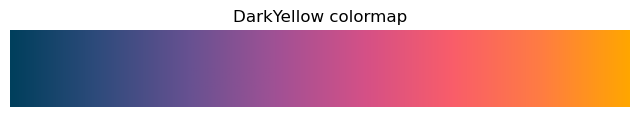

In [19]:
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']

custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)

plt.figure(figsize=(8, 1))
plt.imshow(gradient, aspect="auto", cmap=custom_cmap)
plt.axis("off")
plt.title("DarkYellow colormap")
plt.show()

#with open("DarkYellow_cmap.pkl", "wb") as f:
#    pickle.dump(custom_cmap, f)

# Variabili base

In [20]:
# File containing the images
file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\Algol_1kHz_1_MMStack_Pos0.ome.tif")
file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\febbraio\arcturus_633nm_10ms.ome.tif")
#file =(r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\marzo\4-03\aldebaran_40ms_elev30.tif")
# Select the specific image to study
imagenumber = 1500 #1500#901#900

immagini = tifffile.imread(file)[:5000]  # legge solo le prime 5000 immagini per non occupare troppa RAM

# Define a count per pixel threshold to find the speckles in the images
speckle_threshold=5000 #7000 #1100 #7000 #9500 #8000 #9000 #6500 #9000

# Plate scale arcseconds/pixels
plate_scale = 0.0109 #0.012 #4 MARZO #0.0109 FEBBRAIO# 0.0377 GENNAIO

# Diffraction limit of the telescope
aperture = 1.82                                                     # Aperture of the telescope (in meters)
wavelength = 633e-9 #700e-9                                                 # Reference wavelenght (in meters) 

diffraction_limit_radians = 2*1.22 * wavelength / aperture          # Diameter of the Airy disk
diffraction_limit_arcseconds = diffraction_limit_radians * 206265
expected_speckle_size_radians = 0.8038 *(1.22 * wavelength / aperture)
expected_speckle_size = expected_speckle_size_radians * 206265  
expected_speckle_size_pixels = expected_speckle_size / plate_scale
print("Diffraction limit in arcseconds and pixels: ",diffraction_limit_arcseconds, diffraction_limit_arcseconds/plate_scale)
print("Expected speckle size in arcseconds and pixels: ", expected_speckle_size, expected_speckle_size/plate_scale)

#Radius used to check for speckles (in pixels)
check_radius = int(diffraction_limit_arcseconds*0.5/plate_scale) # corrisponde al raggio del disco di airy in pixel
print ("Check radius in pixels: ", check_radius)




Diffraction limit in arcseconds and pixels:  0.17504418560439558 16.05909959673354
Expected speckle size in arcseconds and pixels:  0.07035025819440659 6.45415212792721
Check radius in pixels:  8


### Apertura file tiff

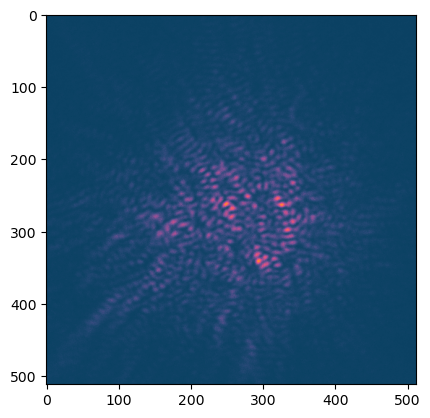

In [21]:
import tifffile


ome_file = file

ome_data = tifffile.imread(ome_file)[:5000]  # legge solo le prime 5000 immagini per non occupare troppa RAM
imagenumber = 300
#informazioni sul file tiff
#print(f"OME-TIFF data shape: {ome_data.shape}")
#print(f"OME-TIFF data type: {ome_data.dtype}")
#print('ome_data.shape[0]',ome_data.shape[0])
#print('ome_data[0].shape',ome_data[0].shape)
# mostra la prima immagine del file tiff 
plt.imshow(ome_data[imagenumber], cmap=custom_cmap)
#plt.title('First Image in OME-TIFF File')
plt.show()
#plt.imshow(ome_data[1], cmap='gray')
#plt.title('Second Image in OME-TIFF File')
#plt.show()

#print('ome_data[0]',ome_data[0])         #è l'immagine intera, se si aggiunge anche il secondo indice si accede alle righe (o colonne) di pixel
#print('len ome_data[0]', len(ome_data[0]))
#print('ome_data[0][1]',ome_data[0][1])
#print('len ome_data[0][1]',len(ome_data[0][1]))

### Salva un'immagine in formato .fits per usarla su DS9

In [6]:
#immagine = ome_data[imagenumber]  #sceglie l'immagine
immagine = immagini[imagenumber]
hdu = fits.PrimaryHDU(immagine)

hdu.writeto('c:/Users/buonc/Desktop/speckle_3x_1ms_singleimage.fits', overwrite=True)

# Stima del background e pulizia dell'immagine

Background level: 1529.0
Background error: 39.102429592034305
[[ 913.0801 1152.7123 1196.2932 ... 1116.0674 1139.8368 1271.5771]
 [1183.4167 1069.5219 1107.154  ... 1134.8848 1155.6836 1206.1985]
 [1167.5691 1163.6073 1173.512  ... 1110.1251 1183.4167 1145.7793]
 ...
 [1252.7552 1605.5111 1563.884  ... 1178.4644 1323.0927 1150.7314]
 [1495.5022 1369.6584 1557.9375 ... 1272.5677 1230.9623 1314.1763]
 [1622.3608 1428.1183 1395.4198 ... 1230.9623 1118.0481 1116.0674]]
(512, 512)


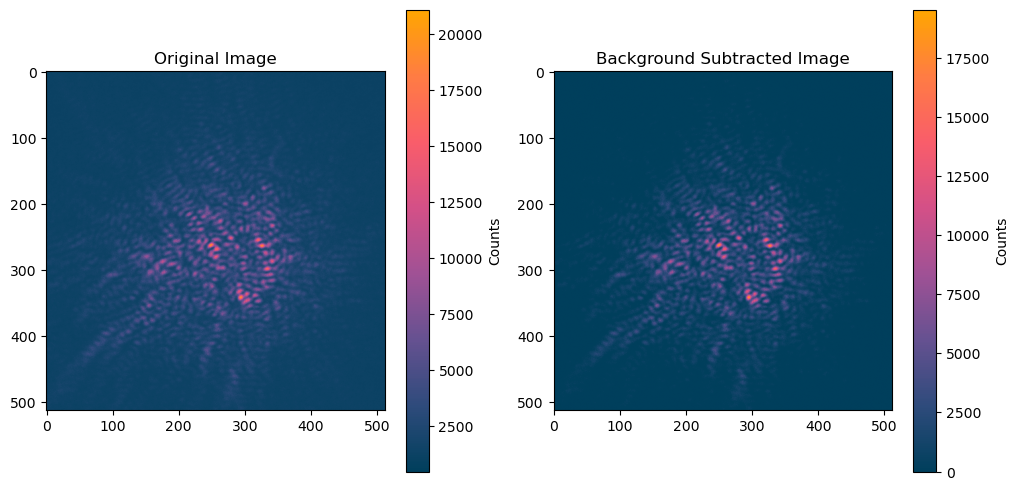

In [22]:
imagenumber = 300
data_raw=ome_data[imagenumber]

poisson_error = np.sqrt(data_raw)

# Estimate the background error (assuming a constant background level)
background_level = np.median(data_raw)
background_error = np.sqrt(background_level)

# Combine the signal and background errors to get the total error
total_error = np.sqrt(poisson_error**2 + background_error**2)

# Estimate the background using the total error
background_estimate = data_raw - total_error

background_estimate[background_estimate < 0] = 0

print(f"Background level: {background_level}")
print(f"Background error: {background_error}")
print(background_estimate)

plt.figure(figsize=(12, 6))

data = data_raw - background_level
data[data<0] = 0
print(data.shape)

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(data_raw, cmap=custom_cmap)
plt.title('Original Image')
plt.colorbar(label='Counts')

# Plot the background subtracted image
plt.subplot(1, 2, 2)
plt.imshow(data, cmap=custom_cmap)
plt.title('Background Subtracted Image')
plt.colorbar(label='Counts')

plt.show()




# Cerca le vere speckle e ne resitutisce le posizioni

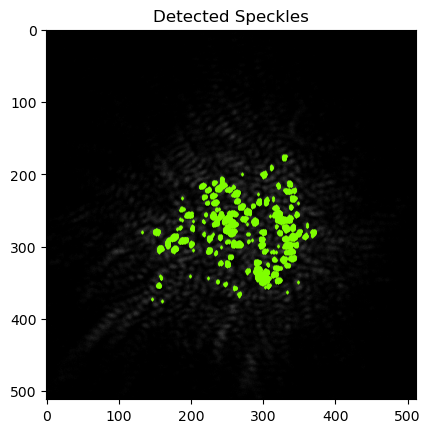

(260, 2)


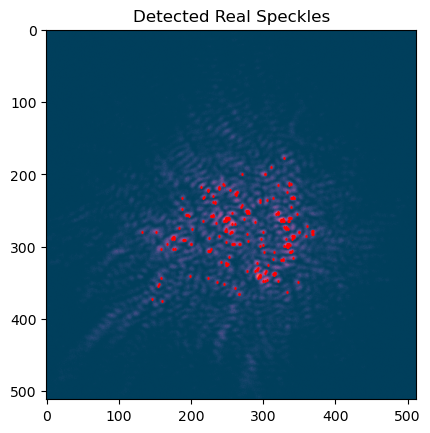

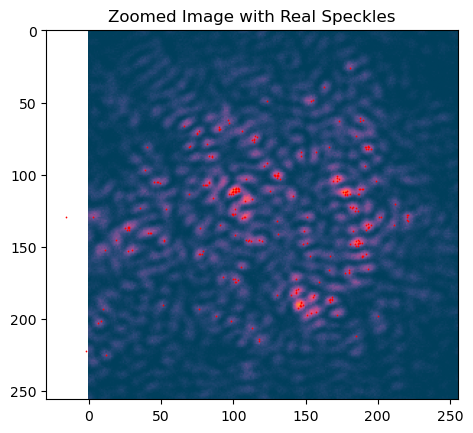

Number of speckles found: 3002
Number of real speckles found: 260


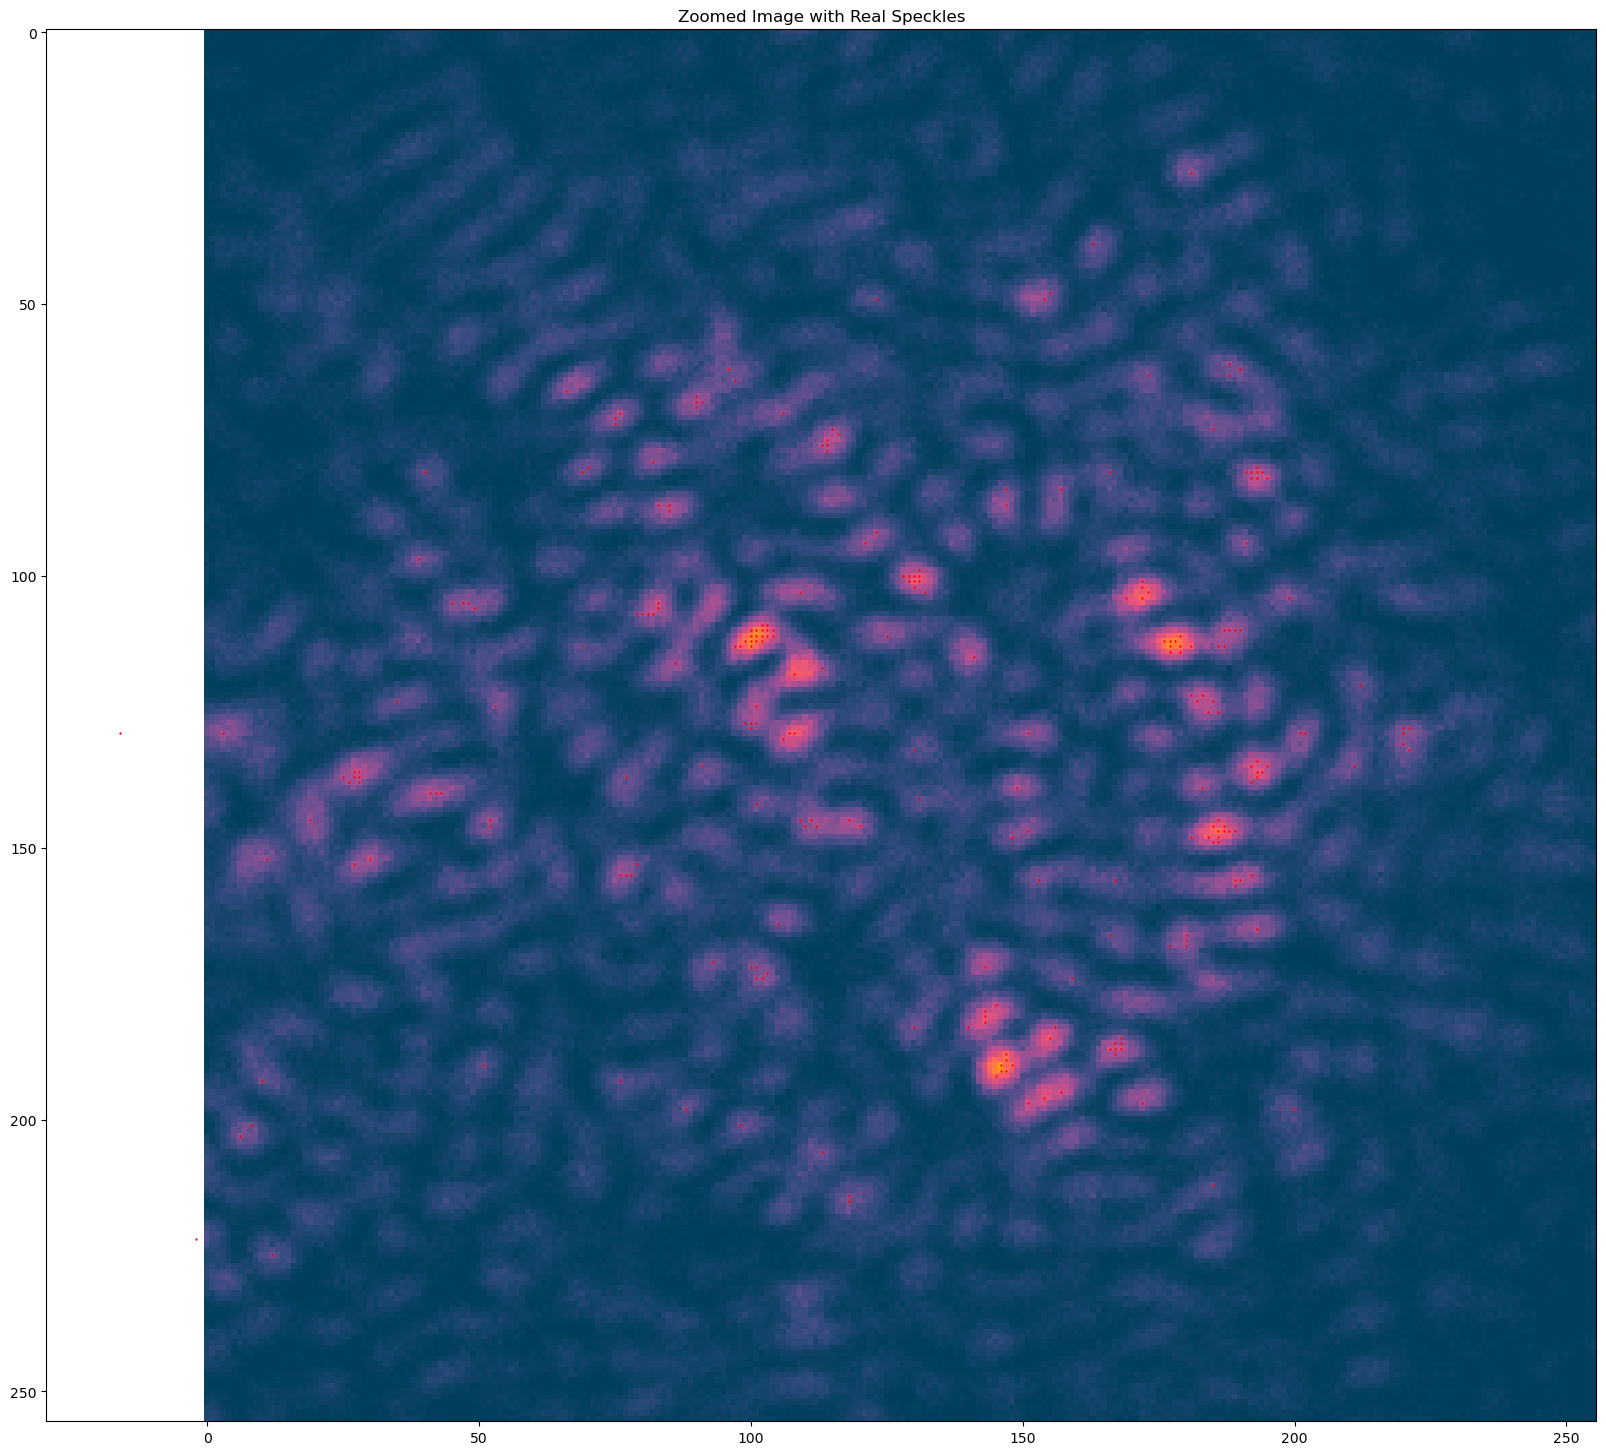

Filtered speckles: 100


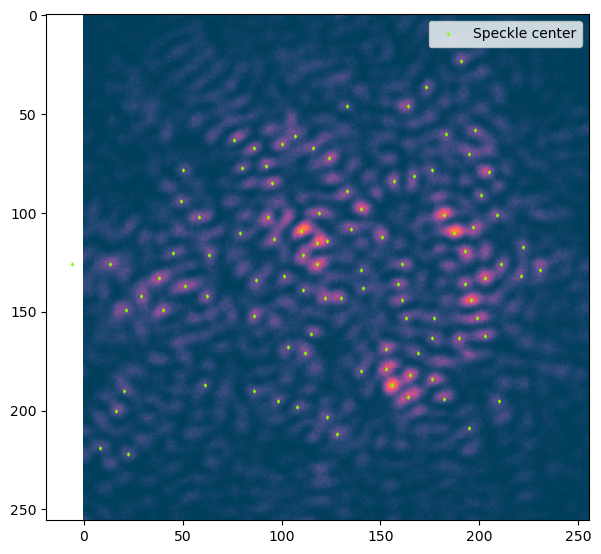

Filtered speckles after removing distant ones: 100


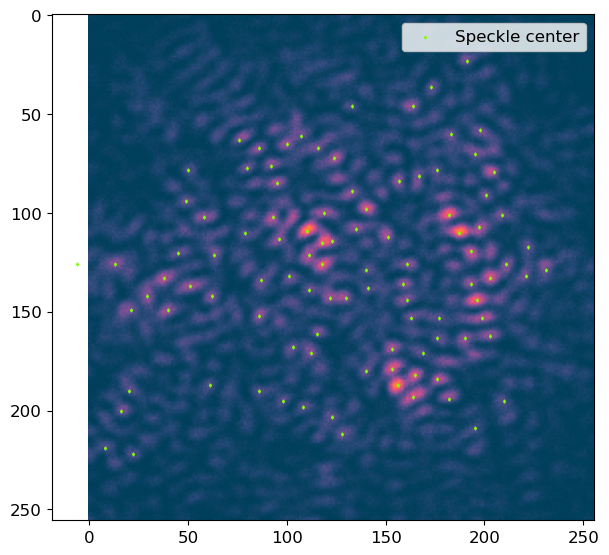

In [23]:

from PIL import Image

logging.getLogger().setLevel(logging.INFO)

#data = ome_data[20]
#speckle_threshold=1500 #10000#7000
# Define the radius to check for a larger count
#check_radius = 4

###############################################################################################
###########################     SOLO PER 10KHZ ################################################
#center_y, center_x = data.shape[0] // 2, data.shape[1] // 2

#search_radius = 80

#y, x = np.ogrid[:data.shape[0], :data.shape[1]]
#mask = (x - center_x)**2 + (y - center_y)**2 <= search_radius**2
################################################################################################
################################################################################################

# Apply the mask to the data to find speckles within the search radius
speckle_coords = np.column_stack(np.where((data > speckle_threshold)))# & mask))


# Show the image with the speckles highlighted 
plt.imshow(data, cmap='gray')
plt.scatter(speckle_coords[:, 1], speckle_coords[:, 0], color='chartreuse', s=2, marker='d')
plt.title('Detected Speckles')
plt.show()

# List to store the real speckles
real_speckles = []

# Iterate over each speckle found
for coord in speckle_coords:
    y, x = coord
    max_count = data[y, x]
    speckle = coord
    
    # Check the surrounding pixels within the radius
    for dy in range(-check_radius, check_radius + 1):
        for dx in range(-check_radius, check_radius + 1):
            ny, nx = y + dy, x + dx
            if 0 <= ny < data.shape[0] and 0 <= nx < data.shape[1]:
                if data[ny, nx] > max_count:
                    max_count = data[ny, nx]
                    speckle = [ny, nx]
                    
    if not any(np.array_equal(speckle, x) for x in real_speckles):
        real_speckles.append(speckle)
    
# Convert real speckles to numpy array
real_speckles = np.array(real_speckles)
print(real_speckles.shape)
# Show the image with the real speckles highlighted using matplotlib
plt.imshow(data, cmap=custom_cmap)
plt.scatter(real_speckles[:, 1], real_speckles[:, 0], color='red', s=1, marker='d')
plt.title('Detected Real Speckles')
plt.show()

# Define the zoom factor
zoom_factor = 2

# Calculate the center of the real speckles
center_x = int(real_speckles[:, 1].mean())
center_y = int(real_speckles[:, 0].mean())

# Define the zoomed area
x1 = max(center_x - data.shape[1] // (2 * zoom_factor), 0)
x2 = min(center_x + data.shape[1] // (2 * zoom_factor), data.shape[1])
y1 = max(center_y - data.shape[0] // (2 * zoom_factor), 0)
y2 = min(center_y + data.shape[0] // (2 * zoom_factor), data.shape[0])

# Crop the zoomed area from the original image
zoomed_image = data[y1:y2, x1:x2]

# Display the zoomed image with the real speckles highlighted
plt.imshow(zoomed_image, cmap=custom_cmap)
plt.scatter(real_speckles[:, 1] - x1, real_speckles[:, 0] - y1, color='red', s=0.1, marker='d')
plt.title('Zoomed Image with Real Speckles')
plt.show()
 
print("Number of speckles found:", len(speckle_coords))
print("Number of real speckles found:", len(real_speckles))

# Save the last plot as an image with very large resolution
fig, ax = plt.subplots(figsize=(20, 20))  # Increase the figure size for higher resolution
ax.imshow(zoomed_image, cmap=custom_cmap)
ax.scatter(real_speckles[:, 1] - x1, real_speckles[:, 0] - y1, color='red', s=0.5, marker='d')
ax.set_title('Zoomed Image with Real Speckles')
#plt.savefig('real_speckles_r=5.png', dpi=500)  # Save with high resolution
plt.show()

# Convert the zoomed image to an 8-bit image
zoomed_image_8bit = (zoomed_image / zoomed_image.max() * 255).astype(np.uint8)

# Save the image in TIFF format
image_with_scatter = Image.fromarray(zoomed_image_8bit)
fig, ax = plt.subplots(figsize=(20, 20))  # Increase the figure size for higher resolution
ax.imshow(zoomed_image_8bit, cmap=custom_cmap)
ax.scatter(real_speckles[:, 1] - x1, real_speckles[:, 0] - y1, color='red', s=0.5, marker='d')
ax.set_title('Zoomed Image with Real Speckles')
fig.canvas.draw()

# Convert the plot with scatter to an image
image_from_plot = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (4,))
image_from_plot = image_from_plot[:, :, 1:]  # Remove the alpha channel
image_with_scatter = Image.fromarray(image_from_plot)
image_with_scatter.save('zoomed_image_with_real_speckles_and_scatter.tiff')
plt.close(fig)



logging.getLogger().setLevel(logging.INFO)


filtered_speckles = []

for speckle in real_speckles:
    y, x = speckle
    max_count = data[y, x]
    keep_speckle = True
    # Check for speckles that are closer than N pixels
    for other_speckle in filtered_speckles:
        distance = np.sqrt((other_speckle[0] - y)**2 + (other_speckle[1] - x)**2)
        if distance < 5:   # change here to change the radius (in pixels)
            if data[other_speckle[0], other_speckle[1]] > max_count:
                keep_speckle = False
            else:
                filtered_speckles = [fs for fs in filtered_speckles if not np.array_equal(fs, other_speckle)]
    
    if keep_speckle:
        filtered_speckles.append([y, x])

# Convert filtered speckles to numpy array
filtered_speckles = np.array(filtered_speckles)

# Print the filtered speckles
print("Filtered speckles:", len(filtered_speckles))

# Define the zoom factor
zoom_factor = 2

# Calculate the center of the filtered speckles
center_x = int(filtered_speckles[:, 1].mean())
center_y = int(filtered_speckles[:, 0].mean())

# Define the zoomed area
x1 = max(center_x - data.shape[1] // (2 * zoom_factor), 0)
x2 = min(center_x + data.shape[1] // (2 * zoom_factor), data.shape[1])
y1 = max(center_y - data.shape[0] // (2 * zoom_factor), 0)
y2 = min(center_y + data.shape[0] // (2 * zoom_factor), data.shape[0])

# Crop the zoomed area from the original image
zoomed_image = data[y1:y2, x1:x2]

# Display the zoomed image with the filtered speckles highlighted
plt.figure(figsize=(7, 7))  # Increase the figure size for larger image
plt.imshow(zoomed_image, cmap=custom_cmap)
plt.scatter(filtered_speckles[:, 1] - x1, filtered_speckles[:, 0] - y1, color='chartreuse', s=2, marker='d', label='Speckle center')
plt.title('')
plt.legend()
plt.show()

###########################################################################################################
############################################ SOLO PER 10KHZ ##############################################
########################################################################################################
# Calculate the barycenter of the filtered speckles
barycenter_x = filtered_speckles[:, 1].mean()
barycenter_y = filtered_speckles[:, 0].mean()

# Define a maximum distance from the barycenter to consider a speckle as valid
max_distance = 70  

# Calculate the distance of each speckle from the barycenter
distances = np.sqrt((filtered_speckles[:, 1] - barycenter_x)**2 + (filtered_speckles[:, 0] - barycenter_y)**2)

###############################################################################################
###########################     SOLO PER 10KHZ ################################################
# Filter out speckles that are farther than the maximum distance from the barycenter
# filtered_speckles = filtered_speckles[distances <= max_distance]
########################################################################################################
########################################################################################################

print("Filtered speckles after removing distant ones:", len(filtered_speckles))
plt.figure(figsize=(7, 7)) 
plt.imshow(zoomed_image, cmap=custom_cmap)
plt.scatter(filtered_speckles[:, 1] - x1, filtered_speckles[:, 0] - y1, color='chartreuse', s=2, marker='d', label='Speckle center')
plt.title('', fontsize='large')
plt.legend(fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.show()




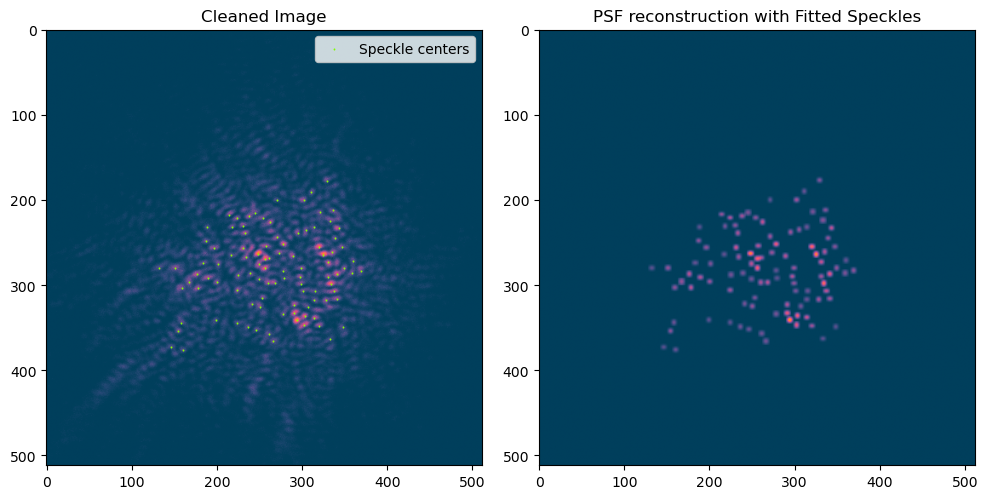

In [8]:
from astropy.modeling import models, fitting
radius=int(0.5*(expected_speckle_size_pixels + 3))#check_radius
# Fit all filtered speckles in the current image using a 2D Gaussian

fwhm_results = []
center_x = []
center_y = []

for speckle in filtered_speckles:
    y_ref, x_ref = speckle
    masked_data = data.copy()
    y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    distance = np.sqrt((x - x_ref)**2 + (y - y_ref)**2)
    circular_mask = distance <= radius
    masked_data = masked_data[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    masked_data = np.where(circular_mask, masked_data, 0)
    masked_data[0, :] = 0
    masked_data[-1, :] = 0
    masked_data[:, 0] = 0
    masked_data[:, -1] = 0

    gaussian_model = models.Gaussian2D(
        amplitude=masked_data.max(),
        x_mean=x_ref,
        y_mean=y_ref,
        x_stddev=0.5,
        y_stddev=0.5
    )
    gaussian_model.amplitude.min = speckle_threshold
    gaussian_model.amplitude.max = masked_data.max()
    gaussian_model.x_mean.min = x_ref - 5
    gaussian_model.x_mean.max = x_ref + 5
    gaussian_model.y_mean.min = y_ref - 5
    gaussian_model.y_mean.max = y_ref + 5

    fitter = fitting.LevMarLSQFitter()
    fitted_model = fitter(gaussian_model, x, y, masked_data)

    fwhm_x = 2.355 * fitted_model.x_stddev.value * plate_scale
    fwhm_y = 2.355 * fitted_model.y_stddev.value * plate_scale
    fwhm_results.append((fwhm_y, fwhm_x))
    center_x.append(fitted_model.x_mean.value)
    center_y.append(fitted_model.y_mean.value)

fwhm_results = np.array(fwhm_results)

import matplotlib.pyplot as plt

# Plot the original image with highlighted speckle positions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(data, cmap=custom_cmap)
plt.scatter(filtered_speckles[:, 1], filtered_speckles[:, 0], color='chartreuse', s=0.2, marker='d', label='Speckle centers')
plt.title('Cleaned Image')
plt.legend()

# Plot all fitted speckles in their fitted shape and position
fitted_image = np.zeros_like(data, dtype=float)
for idx, speckle in enumerate(filtered_speckles):
    y_ref, x_ref = speckle
    y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    # Recreate the Gaussian2D model for each speckle using the fitted parameters
    fwhm_y, fwhm_x = fwhm_results[idx]
    # Convert FWHM back to stddev for Gaussian2D
    stddev_x = fwhm_x / (2.355 * plate_scale)
    stddev_y = fwhm_y / (2.355 * plate_scale)
    amplitude = data[y_ref, x_ref]
    model = models.Gaussian2D(amplitude=amplitude, x_mean=x_ref, y_mean=y_ref, x_stddev=stddev_x, y_stddev=stddev_y)
    patch = model(x, y)
    # Place the patch into the fitted_image, taking care of boundaries
    y1, y2 = max(y_ref-radius, 0), min(y_ref+radius+1, data.shape[0])
    x1, x2 = max(x_ref-radius, 0), min(x_ref+radius+1, data.shape[1])
    patch_y1 = 0 if y_ref-radius >= 0 else -(y_ref-radius)
    patch_y2 = patch.shape[0] if y_ref+radius+1 <= data.shape[0] else patch.shape[0] - (y_ref+radius+1-data.shape[0])
    patch_x1 = 0 if x_ref-radius >= 0 else -(x_ref-radius)
    patch_x2 = patch.shape[1] if x_ref+radius+1 <= data.shape[1] else patch.shape[1] - (x_ref+radius+1-data.shape[1])
    fitted_image[y1:y2, x1:x2] += patch[patch_y1:patch_y2, patch_x1:patch_x2]

plt.subplot(1, 2, 2)
plt.imshow(fitted_image, cmap=custom_cmap)
plt.title('PSF reconstruction with Fitted Speckles')
plt.tight_layout()
plt.show()


# Prova di fit di una sola speckle


Ellipticity: 0.17857241470272012
13592.0
Speckle at (x, y) = (278, 252)
Amplitude: 11806.855312577722
X mean: 278.64104538753946
Y mean: 251.56827868111222
X stddev: 3.3541099937249728
Y stddev: 2.755158472966979
FWHM: 7.898929035222311 x 6.488398203837236 [pixels]
FWHM=0.0860983264839232 x 0.07072354042182587 [arcsec]
fitted FWHM = 0.49186624615174396 x 0.4040325028656645 in units of telescope diffraction limit


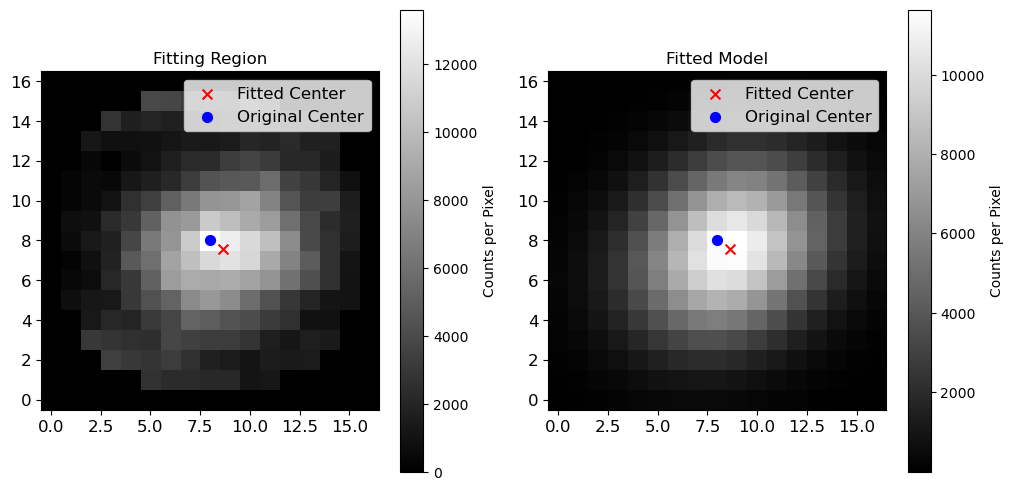

In [17]:
# Select a single speckle for fitting
#data=ome_data[1000]
#data=data-total_noise
#background = 1227
#masked_data=data-background #- speckle_threshold/2 #-background #

masked_data=data.copy()
#masked_data[masked_data < 0] = 0    #mette a 0 i pixel che vanno sotto 0 conteggi per evitare errori  

single_speckle = filtered_speckles[22]
y_ref, x_ref = single_speckle #172,273 #single_speckle #138, 231    #single_speckle
radius=int((diffraction_limit_arcseconds/plate_scale)/2)#int(0.5*expected_speckle_size_pixels + 3)#check_radius  #radius = int(check_radius)  # Define the radius for the fitting region
#plate_scale=0.0377
# Define the fitting region
# Define the fitting region as a circle
y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
distance = np.sqrt((x - x_ref)**2 + (y - y_ref)**2)
circular_mask = distance <= radius
masked_data = masked_data[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
masked_data = np.where(circular_mask, masked_data, 0)

# Set border pixels to 0
masked_data[0, :] = 0
masked_data[-1, :] = 0
masked_data[:, 0] = 0
masked_data[:, -1] = 0

# Initialize the Gaussian model
gaussian_model = models.Gaussian2D(amplitude=data[y_ref, x_ref], x_mean=x_ref, y_mean=y_ref, x_stddev=0.5, y_stddev=0.5) #x_stddev=np.std(data[y_ref-radius:y_ref+radius+1, x_ref]), y_stddev=np.std(data[y_ref, x_ref-radius:x_ref+radius+1]))
gaussian_model.amplitude.min = speckle_threshold #masked_data.max()/2

gaussian_model.amplitude.max = masked_data.max()

# Fit the model to the data
# Impose that the center of the fitted Gaussian remains inside N pixels of the speckle coordinates
gaussian_model.x_mean.min = x_ref - 5#1
gaussian_model.x_mean.max = x_ref + 5#1
gaussian_model.y_mean.min = y_ref - 5#1
gaussian_model.y_mean.max = y_ref + 5#1

fitter = fitting.LevMarLSQFitter()

fitted_model = fitter(gaussian_model, x, y, masked_data)

# Calculate the ellipticity
ellipticity = 1 - (min(fitted_model.x_stddev.value, fitted_model.y_stddev.value) / max(fitted_model.x_stddev.value, fitted_model.y_stddev.value))
print(f"Ellipticity: {ellipticity}")


print(masked_data.max())
print(f"Speckle at (x, y) = ({x_ref}, {y_ref})")
print(f"Amplitude: {fitted_model.amplitude.value}")
print(f"X mean: {fitted_model.x_mean.value}")
print(f"Y mean: {fitted_model.y_mean.value}")
print(f"X stddev: {fitted_model.x_stddev.value}")
print(f"Y stddev: {fitted_model.y_stddev.value}")
print(f"FWHM: {2.355 * fitted_model.x_stddev.value} x {2.355 * fitted_model.y_stddev.value} [pixels]")
print(f"FWHM={(2.355 * fitted_model.x_stddev.value)*plate_scale} x {(2.355 * fitted_model.y_stddev.value)*plate_scale} [arcsec]")
print(f'fitted FWHM = {(2.355 * fitted_model.x_stddev.value)*plate_scale / diffraction_limit_arcseconds} x {(2.355 * fitted_model.y_stddev.value)*plate_scale / diffraction_limit_arcseconds} in units of telescope diffraction limit' )


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
img1 = plt.imshow(masked_data, cmap='gray', origin='lower')
plt.colorbar(img1, label='Counts per Pixel')  # Add colorbar
plt.title('Fitting Region', fontsize='large')
plt.scatter(fitted_model.x_mean.value - x_ref + radius, fitted_model.y_mean.value - y_ref + radius, color='red', marker='x', s=50, label='Fitted Center')
plt.scatter(radius, radius, color='blue', marker='o', s=50, label='Original Center')
plt.legend(fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

plt.subplot(1, 2, 2)
img2 = plt.imshow(fitted_model(x, y), cmap='gray', origin='lower')
plt.colorbar(img2, label='Counts per Pixel')  # Add colorbar
plt.title('Fitted Model', fontsize='large')
plt.scatter(fitted_model.x_mean.value - x_ref + radius, fitted_model.y_mean.value - y_ref + radius, color='red', marker='x', s=50, label='Fitted Center')
plt.scatter(radius, radius, color='blue', marker='o', s=50, label='Original Center')
plt.legend(fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

plt.show()


# Fit con BEssel function

7955.0
Speckle at (x, y) = (313, 183)
Amplitude: 7635.149015666627
X center: 311.73054416242536
Y center: 183.95452355241991
Radius X: 16.0 [pixels]
Radius Y: 16.0 [pixels]
Diameter X: 0.3488 [arcsec]
Diameter Y: 0.3488 [arcsec]
Diameter X as ratio of diffraction limit: 1.9926397371935398
Diameter Y as ratio of diffraction limit: 1.9926397371935398


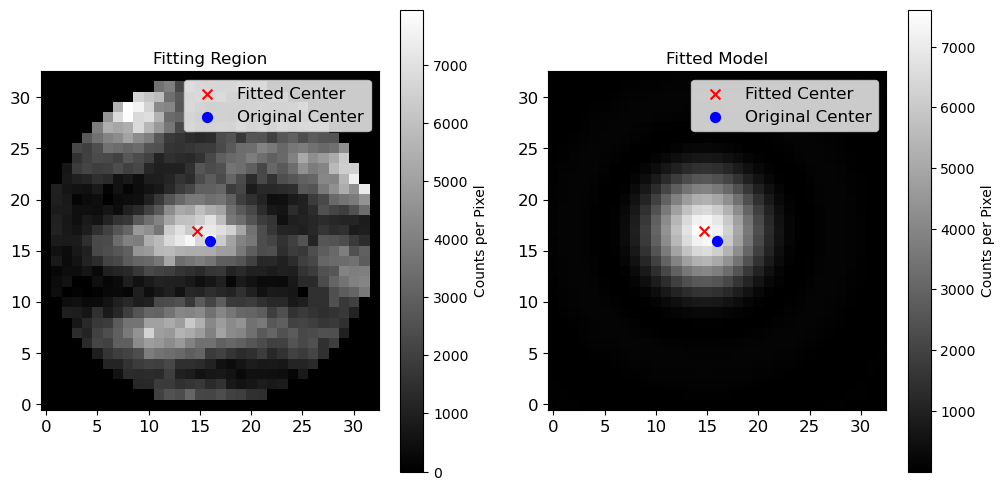

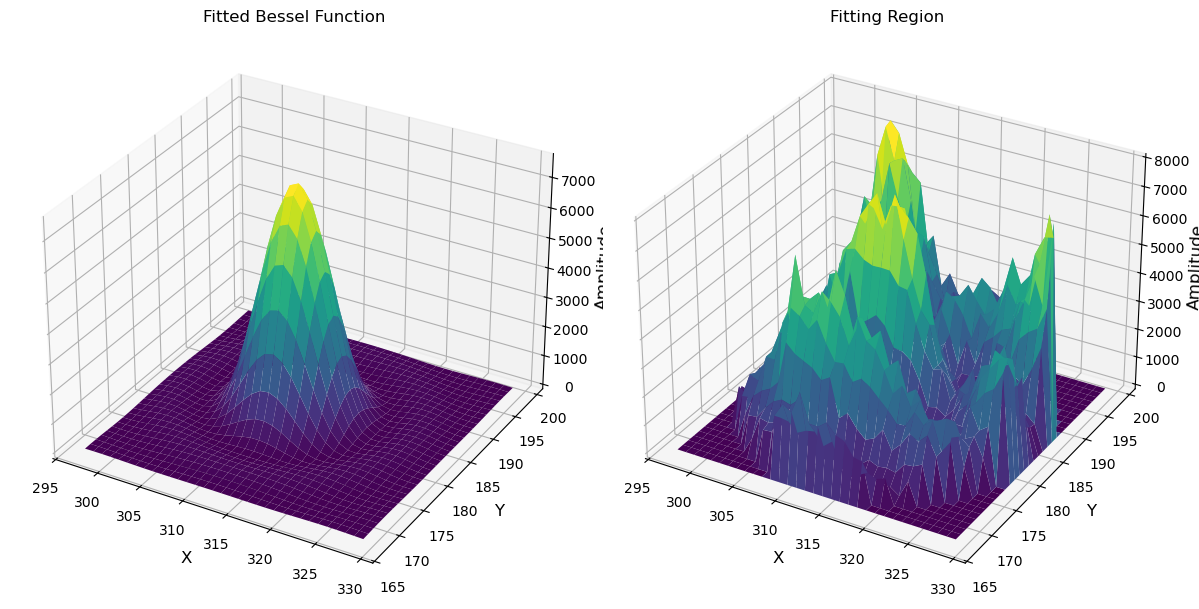

In [ ]:
from astropy.modeling import Fittable2DModel, Parameter
from scipy.special import j1
from mpl_toolkits.mplot3d import Axes3D


# Define a custom Bessel function model
class Bessel2D(Fittable2DModel):
    amplitude = Parameter(default=1.0)
    x_0 = Parameter(default=0.0)
    y_0 = Parameter(default=0.0)
    radius_x = Parameter(default=1.0)
    radius_y = Parameter(default=1.0)

    @staticmethod
    def evaluate(x, y, amplitude, x_0, y_0, radius_x, radius_y):
        r_x = (x - x_0) / radius_x
        r_y = (y - y_0) / radius_y
        r = np.sqrt(r_x**2 + r_y**2)
        # Avoid division by zero
        r[r == 0] = 1e-10
        return amplitude * (2 * j1(2 * np.pi * r) / (2 * np.pi * r))**2

# Initialize the Bessel model
bessel_model = Bessel2D(amplitude=data[y_ref, x_ref], x_0=x_ref, y_0=y_ref, radius_x=10.0, radius_y=10.0)
bessel_model.amplitude.min = speckle_threshold
bessel_model.amplitude.max = masked_data.max()
bessel_model.x_0.min = x_ref - 5
bessel_model.x_0.max = x_ref + 5
bessel_model.y_0.min = y_ref - 5
bessel_model.y_0.max = y_ref + 5
bessel_model.radius_x.min = 1.0
bessel_model.radius_x.max = radius
bessel_model.radius_y.min = 1.0
bessel_model.radius_y.max = radius

# Fit the model to the data
fitter = fitting.LevMarLSQFitter()
fitted_model = fitter(bessel_model, x, y, masked_data)

# Calculate the diameters of the Bessel function
bessel_diameter_x = 2 * fitted_model.radius_x.value * plate_scale
bessel_diameter_y = 2 * fitted_model.radius_y.value * plate_scale

# Calculate the ratio with the diffraction limit
bessel_ratio_x = bessel_diameter_x / diffraction_limit_arcseconds
bessel_ratio_y = bessel_diameter_y / diffraction_limit_arcseconds

print(masked_data.max())
print(f"Speckle at (x, y) = ({x_ref}, {y_ref})")
print(f"Amplitude: {fitted_model.amplitude.value}")
print(f"X center: {fitted_model.x_0.value}")
print(f"Y center: {fitted_model.y_0.value}")
print(f"Radius X: {fitted_model.radius_x.value} [pixels]")
print(f"Radius Y: {fitted_model.radius_y.value} [pixels]")
print(f"Diameter X: {bessel_diameter_x} [arcsec]")
print(f"Diameter Y: {bessel_diameter_y} [arcsec]")
print(f"Diameter X as ratio of diffraction limit: {bessel_ratio_x}")
print(f"Diameter Y as ratio of diffraction limit: {bessel_ratio_y}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
img1 = plt.imshow(masked_data, cmap='gray', origin='lower')
plt.colorbar(img1, label='Counts per Pixel')  # Add colorbar
plt.title('Fitting Region', fontsize='large')
plt.scatter(fitted_model.x_0.value - x_ref + radius, fitted_model.y_0.value - y_ref + radius, color='red', marker='x', s=50, label='Fitted Center')
plt.scatter(radius, radius, color='blue', marker='o', s=50, label='Original Center')
plt.legend(fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

plt.subplot(1, 2, 2)
img2 = plt.imshow(fitted_model(x, y), cmap='gray', origin='lower')
plt.colorbar(img2, label='Counts per Pixel')  # Add colorbar
plt.title('Fitted Model', fontsize='large')
plt.scatter(fitted_model.x_0.value - x_ref + radius, fitted_model.y_0.value - y_ref + radius, color='red', marker='x', s=50, label='Fitted Center')
plt.scatter(radius, radius, color='blue', marker='o', s=50, label='Original Center')
plt.legend(fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

plt.show()
# Create a 3D plot for the fitted Bessel function
fig = plt.figure(figsize=(12, 6))

# fitted Bessel function
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, fitted_model(x, y), cmap='viridis', edgecolor='none')
ax1.set_title('Fitted Bessel Function', fontsize='large')
ax1.set_xlabel('X', fontsize='large')
ax1.set_ylabel('Y', fontsize='large')
ax1.set_zlabel('Amplitude', fontsize='large')

# 3D model of the fitting region
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, masked_data, cmap='viridis', edgecolor='none')
ax2.set_title('Fitting Region', fontsize='large')
ax2.set_xlabel('X', fontsize='large')
ax2.set_ylabel('Y', fontsize='large')
ax2.set_zlabel('Amplitude', fontsize='large')

plt.tight_layout()
plt.show()


# Centroide di un'immagine

Centroid of filtered speckles: (x, y) = (247, 167)


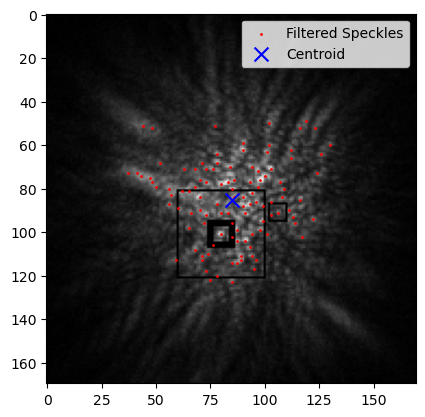

In [ ]:
# Calculate the centroid of the filtered speckles
centroid_x = int(filtered_speckles[:, 1].mean())
centroid_y = int(filtered_speckles[:, 0].mean())

print(f"Centroid of filtered speckles: (x, y) = ({centroid_x}, {centroid_y})")


zoom_factor = 3
x1 = max(centroid_x - data.shape[1] // (2 * zoom_factor), 0)
x2 = min(centroid_x + data.shape[1] // (2 * zoom_factor), data.shape[1])
y1 = max(centroid_y - data.shape[0] // (2 * zoom_factor), 0)
y2 = min(centroid_y + data.shape[0] // (2 * zoom_factor), data.shape[0])

# Crop the zoomed area from the original image
zoomed_data = data[y1:y2, x1:x2]

# Plot the zoomed image with the centroid marked
plt.imshow(zoomed_data, cmap='gray')
plt.scatter(filtered_speckles[:, 1] - x1, filtered_speckles[:, 0] - y1, color='red', s=1, label='Filtered Speckles')
plt.scatter(centroid_x - x1, centroid_y - y1, color='blue', marker='x', s=100, label='Centroid')
plt.legend()
#plt.title('Zoomed Image with Centroid of Filtered Speckles')
plt.show()

# Speckle e centroidi di tutte le immagini 

In [ ]:
#speckle_threshold = 10000
#check_radius = 4

centroid_total = []

for i in range(ome_data.shape[0]-1):
    data = ome_data[i]
    ###################################  #Trova le prime speckles  ######################################################################
    # Per trovare più speckles basta diminuire la treshold e diminuire il raggio entro cui cercare i pixel con conteggi maggiori (check_radius)
    speckle_coords = np.column_stack(np.where(data > speckle_threshold))   
    
    #####################################  #trova le vere speckles   ######################################################################

    real_speckles = []
    for coord in speckle_coords:
        y, x = coord
        max_count = data[y, x]
        speckle = coord

        for dy in range(-check_radius, check_radius + 1):
            for dx in range(-check_radius, check_radius + 1):
                ny, nx = y + dy, x + dx
                if 0 <= ny < data.shape[0] and 0 <= nx < data.shape[1]:
                    if data[ny, nx] > max_count:
                        max_count = data[ny, nx]
                        speckle = [ny, nx]

        if not any(np.array_equal(speckle, x) for x in real_speckles):
            real_speckles.append(speckle)

    real_speckles = np.array(real_speckles)
    
    #####################################  #trova le speckles filtrate   ######################################################

    filtered_speckles = []

    for speckle in real_speckles:
        y, x = speckle
        max_count = data[y, x]
        keep_speckle = True
    
        # Check for adjacent speckles
        for dy in range(-1, 2):
            for dx in range(-1, 2):
                ny, nx = y + dy, x + dx
                if [ny, nx] in filtered_speckles:
                    if data[ny, nx] > max_count:
                        keep_speckle = False
                    else:
                        filtered_speckles.remove([ny, nx])
    
        if keep_speckle:
            filtered_speckles.append([y, x])

    filtered_speckles = np.array(filtered_speckles)

    ################################## Trova il centroide della singola immagine ##############################################

    centroid_x = filtered_speckles[:, 1].mean()
    centroid_y = filtered_speckles[:, 0].mean()
    centroid_total.append([centroid_y, centroid_x])
    
    print(f"Image {i+1}/{ome_data.shape[0]} done")

###################################### standard dev del centroide dell'immagine totale ####################################

centroid_total = np.array(centroid_total)
std_x = np.std(centroid_total[:, 1])
std_y = np.std(centroid_total[:, 0])

print(f"Standard deviation in X: {std_x}")
print(f"Standard deviation in Y: {std_y}")




Image 1/5000 done
Image 2/5000 done
Image 3/5000 done
Image 4/5000 done
Image 5/5000 done
Image 6/5000 done
Image 7/5000 done
Image 8/5000 done
Image 9/5000 done
Image 10/5000 done
Image 11/5000 done
Image 12/5000 done
Image 13/5000 done
Image 14/5000 done
Image 15/5000 done
Image 16/5000 done
Image 17/5000 done
Image 18/5000 done
Image 19/5000 done
Image 20/5000 done
Image 21/5000 done
Image 22/5000 done
Image 23/5000 done
Image 24/5000 done
Image 25/5000 done
Image 26/5000 done
Image 27/5000 done
Image 28/5000 done
Image 29/5000 done
Image 30/5000 done
Image 31/5000 done
Image 32/5000 done
Image 33/5000 done
Image 34/5000 done
Image 35/5000 done
Image 36/5000 done
Image 37/5000 done
Image 38/5000 done
Image 39/5000 done
Image 40/5000 done
Image 41/5000 done
Image 42/5000 done
Image 43/5000 done
Image 44/5000 done
Image 45/5000 done
Image 46/5000 done
Image 47/5000 done
Image 48/5000 done
Image 49/5000 done
Image 50/5000 done
Image 51/5000 done
Image 52/5000 done
Image 53/5000 done
Im

KeyboardInterrupt: 

Standard deviation in X: 11.063774636838257[pixel]
Standard deviation in Y: 11.167218843206243[pixel]
Standard deviation in X: 0.41710430380880226[arcsec]
Standard deviation in Y: 0.42100415038887534[arcsec]


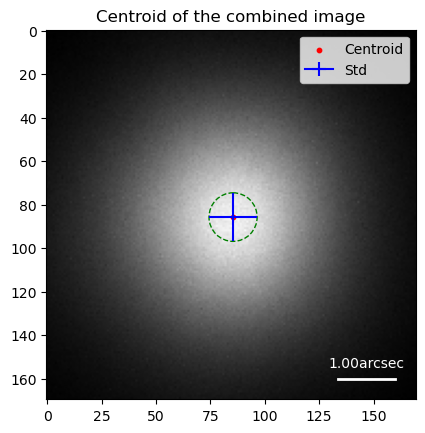

[[158.4        258.67619048]
 [159.43902439 254.93902439]
 [159.86170213 255.09574468]
 ...
 [177.30136986 273.10958904]
 [177.19672131 275.2295082 ]
 [179.77777778 274.49206349]]


In [28]:
from matplotlib.patches import Ellipse
plate_scale=0.0377
centroid_total = np.array(centroid_total)
std_x = np.std(centroid_total[:, 1])
std_y = np.std(centroid_total[:, 0])

print(f"Standard deviation in X: {std_x}[pixel]")
print(f"Standard deviation in Y: {std_y}[pixel]")
print(f"Standard deviation in X: {std_x*plate_scale}[arcsec]")
print(f"Standard deviation in Y: {std_y*plate_scale}[arcsec]")
# Combine all images in ome_data to create a stacked image
stacked_image = np.sum(ome_data, axis=0)


center_x = np.mean(centroid_total[:, 1])
center_y = np.mean(centroid_total[:, 0])  #magari da mettere come numeri interi visto che si tratta di pixel
zoom_factor=3
x1 = max(int(center_x) - stacked_image.shape[1] // (2 * zoom_factor), 0)
x2 = min(int(center_x) + stacked_image.shape[1] // (2 * zoom_factor), stacked_image.shape[1])
y1 = max(int(center_y) - stacked_image.shape[0] // (2 * zoom_factor), 0)
y2 = min(int(center_y) + stacked_image.shape[0] // (2 * zoom_factor), stacked_image.shape[0])

# Crop the zoomed area from the stacked image
zoomed_image = stacked_image[y1:y2, x1:x2]

# Plot the zoomed image with the centroids
plt.imshow(zoomed_image, cmap='gray')
plt.errorbar(center_x - x1, center_y - y1, xerr=std_x, yerr=std_y, color='blue', label='Std')
plt.scatter(center_x - x1, center_y - y1, color='red', marker='o', s=10, label='Centroid')
ellipse = Ellipse((center_x - x1, center_y - y1), width=2*std_x, height=2*std_y, edgecolor='green', fill=False, linestyle='--') #, label='Std Ellipse')
plt.gca().add_patch(ellipse)

# aggiunge una scala al plot
scalebar_length_pixels = 26.52  # lunghezza della barra di scala in pixel
scalebar_length_arcsec = scalebar_length_pixels * plate_scale

scalebar_x = zoomed_image.shape[1] - scalebar_length_pixels - 10
scalebar_y = zoomed_image.shape[0] - 10
plt.plot([scalebar_x, scalebar_x + scalebar_length_pixels], [scalebar_y, scalebar_y], color='white', lw=2)
plt.text(scalebar_x + scalebar_length_pixels / 2, scalebar_y - 5, f'{scalebar_length_arcsec:.2f}arcsec', color='white', ha='center')

plt.title('Centroid of the combined image')
plt.legend()
plt.show()

print(centroid_total)

# Fit delle speckle finali di una sola immagine


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

#radius =
fwhm_results = []
fwhm_tot_single_image = []
center_x = []
center_y = []
rms_tot = []

for speckle in filtered_speckles:
    
    masked_data = data.copy() 
    y_ref, x_ref = speckle  
    # y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
   
    # masked_data = masked_data[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    # masked_data[masked_data < 0] = 0 
    
    y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    distance = np.sqrt((x - x_ref)**2 + (y - y_ref)**2)
    circular_mask = distance <= radius
    masked_data = masked_data[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    
    # se attivo fa il fit in una regione circolare
    masked_data = np.where(circular_mask, masked_data, 0) 
    
    # Set border pixels to 0
    masked_data[0, :] = 0
    masked_data[-1, :] = 0
    masked_data[:, 0] = 0
    masked_data[:, -1] = 0

    gaussian_model = models.Gaussian2D(amplitude=masked_data.max(), x_mean=x_ref, y_mean=y_ref, x_stddev=0.5, y_stddev=0.5)
    gaussian_model.amplitude.min = speckle_threshold
    gaussian_model.amplitude.max = masked_data.max()
    gaussian_model.x_mean.min = x_ref - 1
    gaussian_model.x_mean.max = x_ref + 1
    gaussian_model.y_mean.min = y_ref - 1
    gaussian_model.y_mean.max = y_ref + 1

    fitter = fitting.LevMarLSQFitter()
    fitted_model = fitter(gaussian_model, x, y, masked_data)

    fwhm_x = 2.355 * fitted_model.x_stddev.value * plate_scale
    fwhm_y = 2.355 * fitted_model.y_stddev.value * plate_scale
    fwhm_results.append((fwhm_y, fwhm_x))
    center_x.append(fitted_model.x_mean.value)
    center_y.append(fitted_model.y_mean.value)
    
centroid_x = np.mean(center_x)
centroid_y = np.mean(center_y)
distances = np.sqrt((filtered_speckles[:,1] - centroid_x)**2 + (filtered_speckles[:,0] - centroid_y)**2)
rms_x = np.sqrt(np.mean((center_x - centroid_x)**2)) * plate_scale
rms_y = np.sqrt(np.mean((center_y - centroid_y)**2)) * plate_scale
rms_tot.append((rms_y, rms_x))

fwhm_tot_single_image = np.array(fwhm_results)


print(f"RMS in X: {rms_x} [arcsec]")
print(f"RMS in Y: {rms_y} [arcsec]")
#print (fwhm_tot_single_image)
#print (fwhm_tot_single_image[0,1])
#print(len(fwhm_tot_single_image))

RMS in X: 0.6116932849016243 [arcsec]
RMS in Y: 0.6155348219342773 [arcsec]


# Centroidi di un'immagine calcolato dopo il fit delle speckle

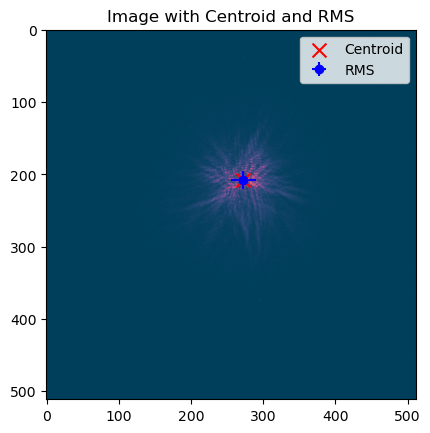

Centroid (x, y): (272.50952042174384, 207.66859215393637)
RMS in X: 16.809944089074538
RMS in Y: 12.614080108938266


In [15]:
# Calculate the centroid of the filtered speckles
centroid_x = np.mean(center_x)
centroid_y = np.mean(center_y)

# Calculate the RMS in X and Y
rms_x = np.sqrt(np.mean((center_x - centroid_x)**2))
rms_y = np.sqrt(np.mean((center_y - centroid_y)**2))

# Plot the image with the centroid and RMS bars
plt.imshow(data, cmap=custom_cmap)
plt.scatter(centroid_x, centroid_y, color='red', marker='x', s=100, label='Centroid')
plt.errorbar(centroid_x, centroid_y, xerr=rms_x, yerr=rms_y, fmt='o', color='blue', label='RMS')
plt.title('Image with Centroid and RMS')
plt.legend()
plt.show()

print(f"Centroid (x, y): ({centroid_x}, {centroid_y})")
print(f"RMS in X: {rms_x}")
print(f"RMS in Y: {rms_y}")


#rms_tot = []

# #SOLO dentro al for delle immagini, non delle single speckle    
# centroid_x = np.mean(center_x)
# centroid_y = np.mean(center_y)
# distances = np.sqrt((filtered_speckles[:,1] - centroid_x)**2 + (filtered_speckles[:,0] - centroid_y)**2)
# rms_x = np.sqrt(np.mean((center_x - centroid_x)**2))
# rms_y = np.sqrt(np.mean((center_y - centroid_y)**2))
# rms_tot.append((rms_y, rms_x))


# print(f"RMS in X: {rms_x}")
# print(f"RMS in Y: {rms_y}")

#max_distance = np.max(distances)
# circle_peaktovalley = plt.Circle((centroid_x, centroid_y), max_distance, color='blue', fill=False)
# circle_rms = plt.Circle((centroid_x, centroid_y), np.sqrt(np.mean(distances**2)), color='yellow', fill=False)   #rms = np.sqrt(np.mean(y**2))  dà la rms della distribuzione delle distanze, NON STD
# plt.imshow(data, cmap=custom_cmap)
# plt.scatter(centroid_x, centroid_y, color='red', marker='s', s=15, label='barycenter')
# plt.scatter(filtered_speckles[:,1], filtered_speckles[:,0], color='green', s=0.1, facecolors='none', label='speckles')
# plt.scatter(filtered_speckles[np.argmax(distances), 1], filtered_speckles[np.argmax(distances), 0], color='white', marker='x', s=25, label='most distant speckle')
# plt.gca().add_patch(circle_rms) #, title='RMS')
# plt.gca().add_patch(circle_peaktovalley) #, title='Peak-to-valley')
# plt.text(centroid_x, centroid_y + max_distance + 5, f'Peak-to-valley: {max_distance:.2f}', color='blue', ha='center')
# plt.text(centroid_x, centroid_y + np.sqrt(np.mean(distances**2)) + 5, f'RMS: {rms:.2f}', color='yellow', ha='center')
# #plt.title('Zoom in barycenter')
# #plt.scatter(159, 257, color='red', marker='s', s=15, label='barycenter')
# plt.legend(loc='best', fontsize='small')
# plt.show()

# print(f"x baricentro= {centroid_x}, y baricentro= {centroid_y}")

# print(np.argmax(distances))
# print(len(distances))
# print(max_distance)


### Centroide con zoom per grafici della relazione

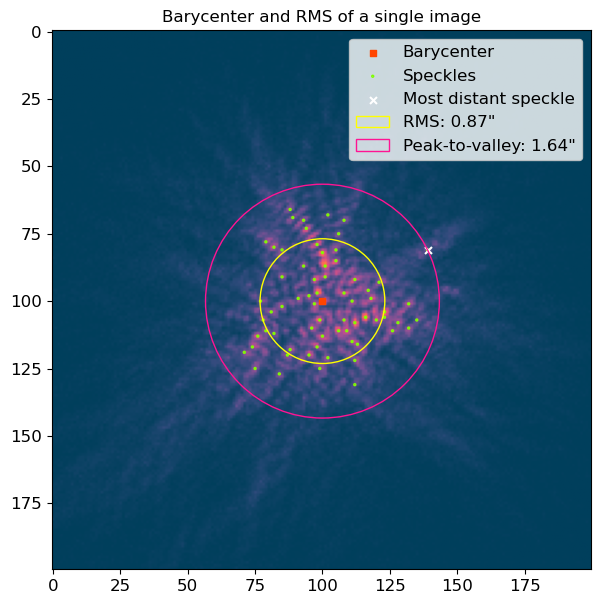

x baricentro= 263.0, y baricentro= 201.0
13
67
43.382023926967726


In [44]:
centroid_x = np.mean(center_x)
centroid_y = np.mean(center_y)


zoom = 100 #più alto è il numero minore è l'ingrandimento, serve a definire il raggio (in pixel) dell'immagine con zoom
zoomed_data = data[int(centroid_y)-zoom:int(centroid_y)+zoom, int(centroid_x)-zoom:int(centroid_x)+zoom]

distances = np.sqrt((filtered_speckles[:,1] - centroid_x)**2 + (filtered_speckles[:,0] - centroid_y)**2)
max_distance = np.max(distances)
circle_peaktovalley = plt.Circle((zoom, zoom), max_distance, color='deeppink', fill=False)
circle_rms = plt.Circle((zoom,zoom),np.sqrt(np.mean(distances**2)), color='yellow', fill=False)   #rms = np.sqrt(np.mean(y**2))  dà la rms della distribuzione delle distanze, NON STD
rms =  np.sqrt(np.mean(distances**2))
plt.figure(figsize=(7, 7))
plt.imshow(zoomed_data, cmap=custom_cmap)
plt.scatter(zoom, zoom, color='orangered', marker='s', s=15, label='Barycenter')
plt.scatter(filtered_speckles[:,1] - int(centroid_x) + zoom, filtered_speckles[:,0] - int(centroid_y) + zoom, color='chartreuse', s=2, facecolors='none', label='Speckles')
plt.scatter(filtered_speckles[np.argmax(distances), 1] - int(centroid_x) + zoom, filtered_speckles[np.argmax(distances), 0] - int(centroid_y) + zoom, color='white', marker='x', s=25, label='Most distant speckle')
plt.gca().add_patch(circle_rms)
plt.gca().add_patch(circle_peaktovalley)
plt.text(zoom, zoom + max_distance + 5, '', color='blue', ha='center', fontsize='large')
plt.text(zoom, zoom + np.sqrt(np.mean(distances**2)) + 5, '', color='yellow', ha='center', fontsize='large')
plt.title('Barycenter and RMS of a single image', fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.legend(loc='best', fontsize='large', labels=[
    'Barycenter', 
    'Speckles', 
    'Most distant speckle', 
    f'RMS: {rms*plate_scale:.2f}"', 
    f'Peak-to-valley: {max_distance*plate_scale:.2f}"'
])
plt.show()

print(f"x baricentro= {centroid_x}, y baricentro= {centroid_y}")
print(np.argmax(distances))
print(len(distances))
print(max_distance)

# Distribuzione delle FWHM di un'immagine 

In [14]:
# Remove outliers from the FWHM distribution
mean_fwhm = np.mean(fwhm_tot_single_image[:, 1])
std_fwhm = np.std(fwhm_tot_single_image[:, 1])
fwhm_tot_clean = fwhm_tot_single_image[(fwhm_tot_single_image[:, 1] > mean_fwhm - 2 * std_fwhm) & (fwhm_tot_single_image[:, 1] < mean_fwhm + 2 * std_fwhm)]
#fwhm_tot_clean = fwhm_tot_single_image
print (len(fwhm_tot_single_image), len(fwhm_tot_clean))

40 37


37
Number of elements per bin: [ 3.  5.  7.  9. 10.  2.  1.]
0.1893993994175025


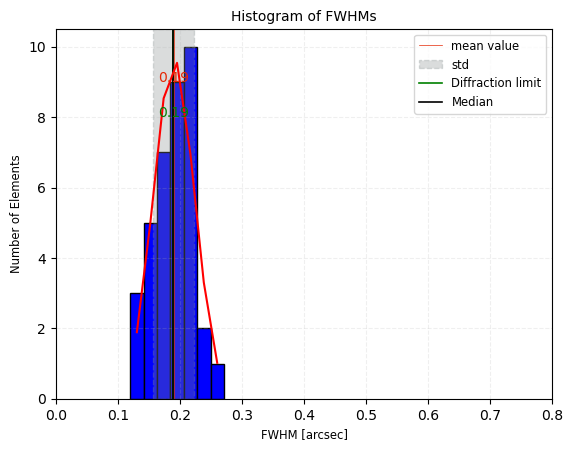

In [15]:
#fwhm_tot_clean = fwhm_tot_single_image

print (len(fwhm_tot_clean))

def gaussiana(bins, media, sigma):
	x = np.zeros(len(bins)-1)
	for i in range(len(x)):
		x[i] = (bins[i]+bins[i+1])/2
	y = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-media)**2/(2*sigma**2))
	return x, y


num_bins= int(len(fwhm_tot_clean) /5)
# Generate the histogram with the optimal number of bins
bin_counts, bins, _ = plt.hist(fwhm_tot_clean[:, 1], bins=num_bins, histtype='bar', align='mid', color='blue', edgecolor='black')
#bin_counts, bins, ign = plt.hist(fwhm_tot_clean[:,1], bins=20, histtype='bar', align='mid', color='blue', edgecolor='black') 
plt.grid(True, linestyle='--', alpha=0.2)
plt.xlabel('FWHM [arcsec]', fontsize='small')
plt.ylabel('Number of Elements', fontsize='small')
plt.title('Histogram of FWHMs', fontsize='medium')
plt.xlim(0, 0.8)
plt.axvline(np.mean(fwhm_tot_clean[:,1]), ls='-', color='#e52704', label='mean value', linewidth=0.5)
plt.axvspan(xmin=np.mean(fwhm_tot_clean[:,1])-np.std(fwhm_tot_clean[:,1]), xmax=np.mean(fwhm_tot_clean[:,1])+np.std(fwhm_tot_clean[:,1]), alpha=0.3, color='#858e8e', label='std', ls='--')
plt.axvline(diffraction_limit_arcseconds, color='green', linestyle='-', linewidth=1.2, label='Diffraction limit')
plt.axvline(np.median(fwhm_tot_clean), color='black', linestyle='-', linewidth=1.2, label='Median')
plt.text(np.mean(fwhm_tot_clean[:,1]), max(bin_counts) * 0.9, f"{np.mean(fwhm_tot_clean[:,1]):.2f}", color='#e52704', ha='center')
plt.text(diffraction_limit_arcseconds, max(bin_counts) * 0.8, f"{diffraction_limit_arcseconds:.2f}", color='green', ha='center')
x, y = gaussiana(bins, np.mean(fwhm_tot_clean[:,1]), np.std(fwhm_tot_clean[:,1]))
plt.plot(x, y * len(fwhm_tot_clean) * (bins[1] - bins[0]), color='red', linestyle='-') 
plt.legend(loc='best', fontsize='small')

print(f"Number of elements per bin: {bin_counts}")
print(np.median(fwhm_tot_clean))


### Posizione del baricentro con grafico delle posizioni delle speckle

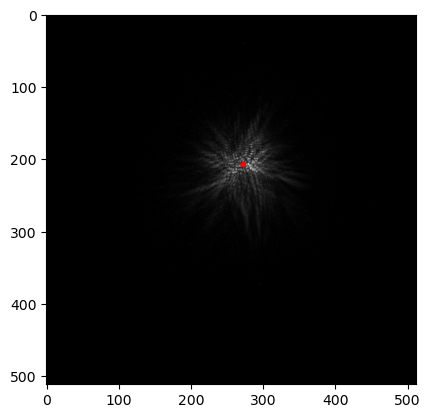

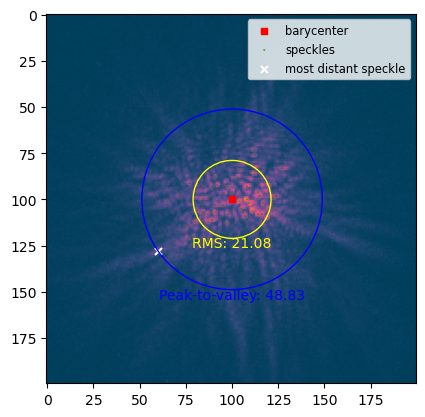

x baricentro= 272, y baricentro= 207
55
56
48.82622246293481


In [21]:
#print(coordinates[0,0], coordinates[0,1])  #il primo è la y la seconda la x
#print(coordinates[1,0], coordinates[1,1])  #questo è il secondo punto nell'elenco
barycenter_x=filtered_speckles[:,1].mean()
barycenter_y=filtered_speckles[:,0].mean()
barycenter_x = int(barycenter_x)
barycenter_y = int(barycenter_y)

plt.imshow(data, cmap='gray')
plt.scatter(barycenter_x, barycenter_y, color='red', marker='P', s=10) #, facecolors='none')
#plt.scatter(barycenter_y, barycenter_x, color='red', marker='P', s=10)
plt.show()

zoom = 100 #più alto è il numero minore è l'ingrandimento, serve a definire il raggio (in pixel) dell'immagine con zoom
zoomed_data = data[int(barycenter_y)-zoom:int(barycenter_y)+zoom, int(barycenter_x)-zoom:int(barycenter_x)+zoom]

distances = np.sqrt((filtered_speckles[:,1] - barycenter_x)**2 + (filtered_speckles[:,0] - barycenter_y)**2)
max_distance = np.max(distances)
circle_peaktovalley = plt.Circle((zoom, zoom), max_distance, color='blue', fill=False)
circle_rms = plt.Circle((zoom,zoom),np.sqrt(np.mean(distances**2)), color='yellow', fill=False)   #rms = np.sqrt(np.mean(y**2))  dà la rms della distribuzione delle distanze, NON STD
rms =  np.sqrt(np.mean(distances**2))

plt.imshow(zoomed_data, cmap=custom_cmap)
plt.scatter(zoom, zoom, color='red', marker='s', s=15, label='barycenter')
plt.scatter(filtered_speckles[:,1] - int(barycenter_x) + zoom, filtered_speckles[:,0] - int(barycenter_y) + zoom, color='green', s=0.1, facecolors='none', label='speckles')
plt.scatter(filtered_speckles[np.argmax(distances), 1] - int(barycenter_x) + zoom, filtered_speckles[np.argmax(distances), 0] - int(barycenter_y) + zoom, color='white', marker='x', s=25, label='most distant speckle')
plt.gca().add_patch(circle_rms) #, title='RMS')
plt.gca().add_patch(circle_peaktovalley) #, title='Peak-to-valley')
plt.text(zoom, zoom + max_distance + 5, f'Peak-to-valley: {max_distance:.2f}', color='blue', ha='center')
plt.text(zoom, zoom + np.sqrt(np.mean(distances**2)) + 5, f'RMS: {rms:.2f}', color='yellow', ha='center')
#plt.title('Zoom in barycenter')
#plt.scatter(159, 257, color='red', marker='s', s=15, label='barycenter')
plt.legend(loc='best', fontsize='small')
plt.show()

print(f"x baricentro= {barycenter_x}, y baricentro= {barycenter_y}")

print(np.argmax(distances))
print(len(distances))
print(max_distance)

In [20]:
print(data[int(barycenter_x), int(barycenter_y)])
print(barycenter_x, barycenter_y)
print(data[159,257])

1392
257 159
8549


159
257 159
159
Maximum value in the data matrix: 32599
(318, 318) (318, 318) (318, 318)
STD= 59.176876092406324 101.92023176898294
Amplitude: 8549.0
X mean: 251.77367393107747
Y mean: 160.64460054102577
X stddev: 62.37853059233157
Y stddev: 63.83363702135853
FWHM=146.89021421839868 [pixel]
FWHM=5.53776107603363 [arcsec]


C:\Users\buonc\AppData\Local\Temp\ipykernel_7484\2620746596.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\buonc\AppData\Local\Temp\ipykernel_7484\2620746596.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


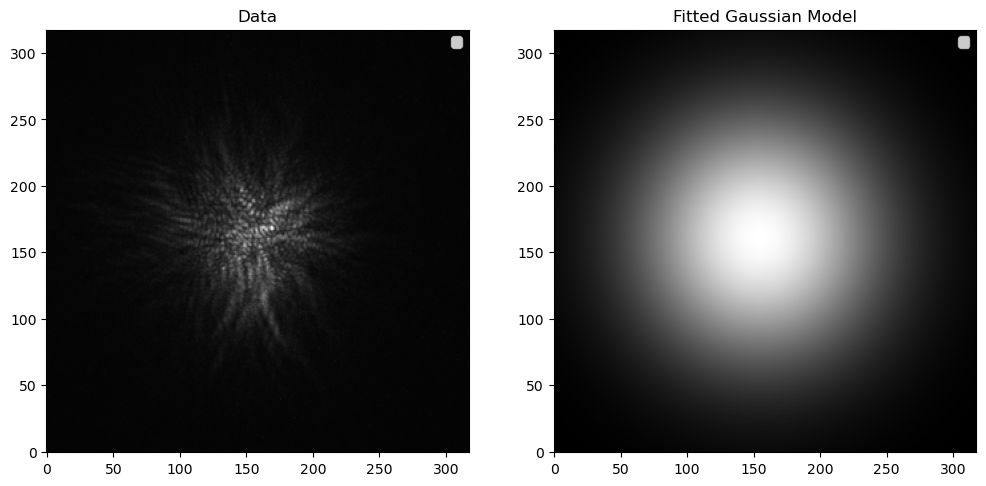

In [21]:
from astropy.modeling import models, fitting

#y_ref=coordinates[i,0]   con 0 è la y
#x_ref=coordinates[i,1]   con 1 è la x      l'indice i identifica il punto invece
#data[i,j]                con i è la y e j la x e così si ha il valore del flusso in quel pixel 
#data_clean=data-background
data_clean=data              #togliere il background dà problemi di overflow e ritrovano valori molto alti di conteggi dove dovrebbe esserci il background.
                              #si può usare per togliere background dal fit delle speckle ma non in questo fit dell'intera immagine.
radius = 3*np.max(distances)
radius=int(radius)

if radius>barycenter_y or radius>barycenter_x:
    radius=min(barycenter_y, barycenter_x)
print(radius)
print(barycenter_x, barycenter_y)
print(radius)

y, x = np.mgrid[barycenter_y-radius:barycenter_y+radius, barycenter_x-radius:barycenter_x+radius]
gaussian_model = models.Gaussian2D(amplitude=data_clean[barycenter_y, barycenter_x], x_mean=barycenter_x, y_mean=barycenter_y, x_stddev=np.std(data[x,1]), y_stddev=np.std(data[y,0])) #,x_stddev=5,y_stddev=5)
gaussian_model.amplitude.min = data_clean[barycenter_y, barycenter_x]
gaussian_model.amplitude.max = np.max(data_clean) #data_clean[barycenter_y-radius:barycenter_y+radius, barycenter_x-radius:barycenter_x+radius].sum() #/10
fitter = fitting.LevMarLSQFitter()

max_value = np.max(data_clean)
print(f"Maximum value in the data matrix: {max_value}")


masked_data = data[barycenter_y-radius:barycenter_y+radius, barycenter_x-radius:barycenter_x+radius]
fitted_gaussian = fitter(gaussian_model, x, y, masked_data)

fwhm_gauss = 2.0*np.sqrt(2.0*np.log(2.0))*fitted_gaussian.x_stddev.value

print(masked_data.shape, x.shape, y.shape)
print("STD=",np.std(data[x,1]),np.std(data[y,0]))
print(f"Amplitude: {fitted_gaussian.amplitude.value}")
print(f"X mean: {fitted_gaussian.x_mean.value}")
print(f"Y mean: {fitted_gaussian.y_mean.value}")
print(f"X stddev: {fitted_gaussian.x_stddev.value}")
print(f"Y stddev: {fitted_gaussian.y_stddev.value}")
print(f"FWHM={fwhm_gauss} [pixel]")
print(f"FWHM={fwhm_gauss*plate_scale} [arcsec]")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(masked_data, cmap='gray', origin='lower')
plt.title('Data')
#plt.scatter(barycenter_x, barycenter_y, color='red', marker='x', s=50, label='Barycenter')
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(fitted_gaussian(x, y), cmap='gray', origin='lower')
plt.title('Fitted Gaussian Model')
#plt.scatter(fitted_gaussian.x_mean.value-radius, fitted_gaussian.y_mean.value-radius, color='red', marker='x', s=50, label='Fitted Center')
plt.legend()

plt.show()



# Generazione dello stack di immagini

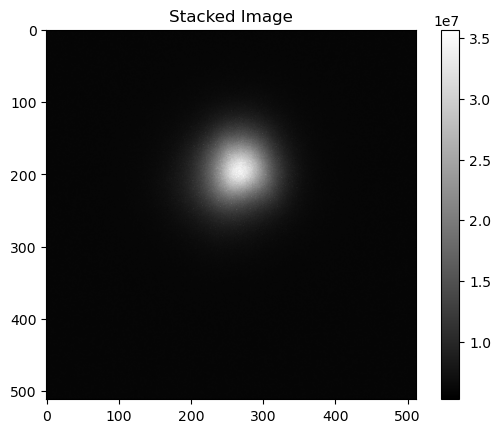

Counts in the first pixel of the first image in the stack: 1175
5861226


In [72]:
image_stack = np.sum(ome_data[:5000], axis=0)  #somma delle immagini 

plt.imshow(image_stack, cmap='gray')
plt.title('Stacked Image')
plt.colorbar()
plt.show()

print("Counts in the first pixel of the first image in the stack:", ome_data[0, 0, 0])
print(image_stack[0, 0])


### salva in file .fits lo stack di immagini

In [73]:
immagine = image_stack  #sceglie l'immagine

hdu = fits.PrimaryHDU(immagine)

hdu.writeto('c:/Users/buonc/Desktop/Algol_1kHz_stack.fits', overwrite=True)

### Fit gaussiano dello stack di immagini

272 207
146
Maximum value in the data matrix: 35704094
Min value in the data matrix: 5259278
STD= 49108.91418126071 100676.6518025427
x_stdv=49108.91418126071, y_stdv=100676.6518025427
(292, 292) (292, 292) (292, 292)
Amplitude: 30817041.0
fit X mean: -227948.86441232555
fit Y mean: -1213192.8513462422
fit X stddev: 1.1754943508222875e-38
fit Y stddev: 1.1754943508222875e-38
FWHM=2.7680776601369656e-38 [pixel]
FWHM=1.0435652778716359e-39 [arcsec]


C:\Users\buonc\AppData\Local\Temp\ipykernel_20900\698978230.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\buonc\AppData\Local\Temp\ipykernel_20900\698978230.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


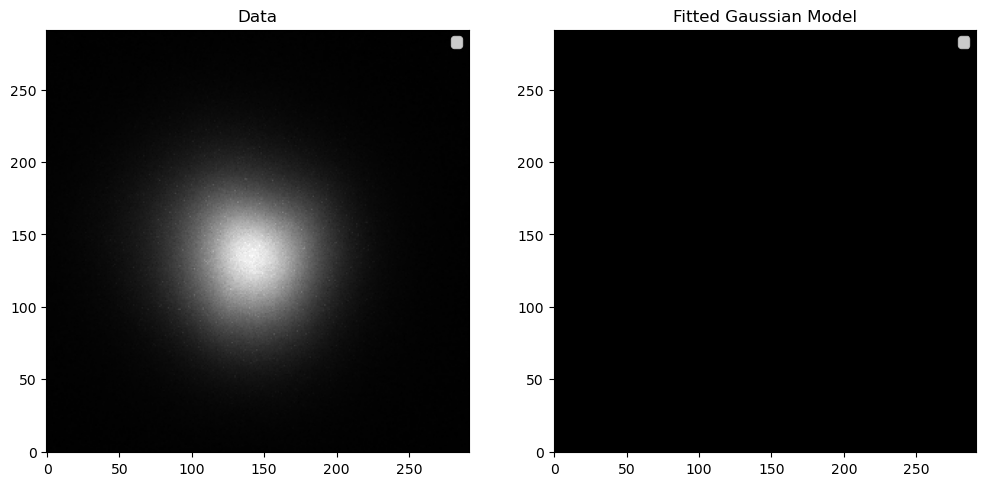

In [ ]:

radius = int(3*np.max(distances))

if radius>barycenter_y or radius>barycenter_x:
    radius=min(barycenter_y, barycenter_x)
    
y, x = np.mgrid[barycenter_y-radius:barycenter_y+radius, barycenter_x-radius:barycenter_x+radius]
    

print(barycenter_x, barycenter_y)
print(radius)
gaussian_model = models.Gaussian2D(amplitude=image_stack[barycenter_y, barycenter_x], x_mean=barycenter_x, y_mean=barycenter_y, x_stddev=np.std(image_stack[x,1]), y_stddev=np.std(image_stack[y,0]))
gaussian_model.amplitude.min = image_stack[barycenter_y, barycenter_x]
gaussian_model.amplitude.max = np.max(image_stack) #data_clean[barycenter_y-radius:barycenter_y+radius, barycenter_x-radius:barycenter_x+radius].sum() #/10
fitter = fitting.LevMarLSQFitter()

max_value = np.max(image_stack)
print(f"Maximum value in the data matrix: {max_value}")
min_value=np.min(image_stack)
print(f"Min value in the data matrix: {min_value}")



masked_stack = image_stack[barycenter_y-radius:barycenter_y+radius, barycenter_x-radius:barycenter_x+radius]
fitted_gaussian = fitter(gaussian_model, x, y, masked_stack)

fwhm_gauss = 2.0*np.sqrt(2.0*np.log(2.0))*fitted_gaussian.x_stddev.value

max_value = np.max(image_stack)

print("STD=", np.std(image_stack[x,1]), np.std(image_stack[y,0]))
print(f"x_stdv={np.std(image_stack[x,1])}, y_stdv={np.std(image_stack[y,0])}")
print(masked_stack.shape, x.shape, y.shape)
print(f"Amplitude: {fitted_gaussian.amplitude.value}")
print(f"fit X mean: {fitted_gaussian.x_mean.value}")
print(f"fit Y mean: {fitted_gaussian.y_mean.value}")
print(f"fit X stddev: {fitted_gaussian.x_stddev.value}")
print(f"fit Y stddev: {fitted_gaussian.y_stddev.value}")
print(f"FWHM={fwhm_gauss} [pixel]")
print(f"FWHM={fwhm_gauss*plate_scale} [arcsec]")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(masked_stack, cmap='gray', origin='lower')
plt.title('Data')
#plt.scatter(barycenter_x, barycenter_y, color='red', marker='x', s=50, label='Barycenter')
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(fitted_gaussian(x, y), cmap='gray', origin='lower')
plt.title('Fitted Gaussian Model')
#plt.scatter(fitted_gaussian.x_mean.value-radius, fitted_gaussian.y_mean.value-radius, color='red', marker='x', s=50, label='Fitted Center')
plt.legend()

plt.show()


# FIT della PSF con fotometria

max value no cleaning = 35704094
Background mean counts per pixel: 6050072.317990417
max counts in the image: 29654021.682009585
R 80 = 71 pixels, 2.6767 arcsec


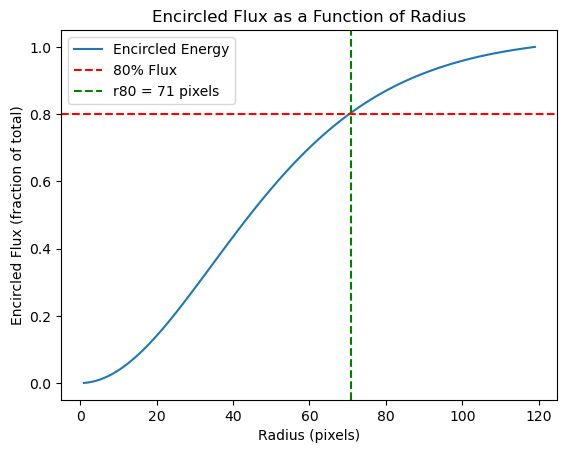

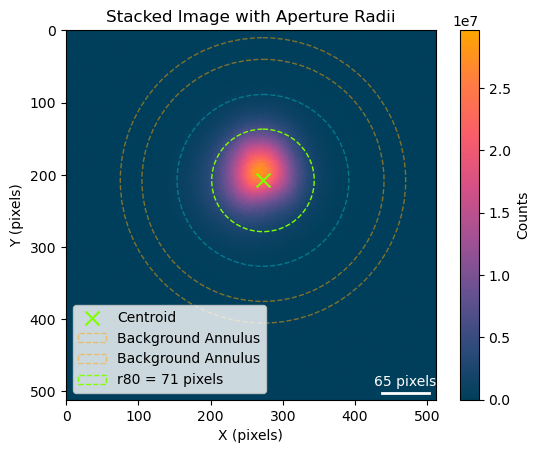

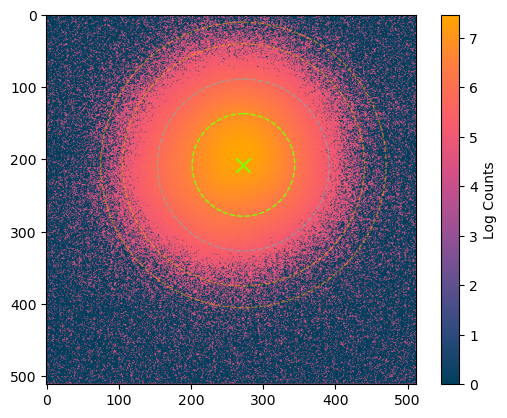

In [80]:
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.aperture import ApertureStats
from astropy.io import fits

#pulizia immagini dal background prima della somma

image_stack_noclean = np.sum(ome_data[:5000], axis=0)

center = (centroid_x, centroid_y)
max_radius = min(center[1], center[0], image_stack.shape[0] - center[0], image_stack.shape[1] - center[1])
max_radius_ds9 = 120 # raggio della PSF visto in DS9 (controllare da lì prima di partire col codice)

inner_radius = max_radius - 40
outer_radius = max_radius - 10
annulus_aperture = CircularAnnulus(center, r_in=inner_radius, r_out=outer_radius)

# Perform aperture photometry on the annulus to get the background
annulus_stats = ApertureStats(image_stack_noclean, annulus_aperture)
background_mean = annulus_stats.mean
image_stack = image_stack_noclean.copy() - background_mean
image_stack[image_stack < 0] = 0

print(f'max value no cleaning = {np.max(image_stack_noclean)}')
print(f"Background mean counts per pixel: {background_mean}")
print(f'max counts in the image: {np.max(image_stack)}')



radii = np.arange(1, max_radius_ds9, 1)

fluxes = []

for r in radii:
    aperture = CircularAperture(center, r)
    phot_table = aperture_photometry(image_stack, aperture)
    flux = phot_table['aperture_sum'][0]
    if len(fluxes) > 0 and (flux - fluxes[-1]) / fluxes[-1] < 0.0001:
        break
    fluxes.append(flux)

# Convert fluxes to a numpy array
fluxes = np.array(fluxes)
total_flux = fluxes[-1]

# Find the radius at which 80% of the total flux is contained
r80 = radii[np.where(fluxes >= 0.8 * total_flux)[0][0]]

print(f"R 80 = {r80} pixels, {r80 * plate_scale} arcsec")

# Plot the flux as a function of radius
plt.figure()
plt.plot(radii[:len(fluxes)], fluxes / total_flux , label='Encircled Energy')
plt.axhline(0.8, color='r', linestyle='--', label='80% Flux')
plt.axvline(r80, color='g', linestyle='--', label=f'r80 = {r80} pixels')
plt.xlabel('Radius (pixels)')
plt.ylabel('Encircled Flux (fraction of total)')
plt.legend()
plt.title('Encircled Flux as a Function of Radius')
plt.show()

# Plot the stacked image with the aperture radii
plt.figure()
plt.imshow(image_stack, cmap=custom_cmap)
plt.colorbar(label='Counts')
plt.scatter(center[0], center[1], color='chartreuse', marker='x', s=100, label='Centroid')

# Plot the aperture radii

aperture = plt.Circle(center, radii[len(fluxes)-1], color='cyan', fill=False, linestyle='--', alpha=0.3)
plt.gca().add_patch(aperture)

# Plot the annulus for background estimation
annulus_aperture_patch = plt.Circle(center, outer_radius, color='orange', fill=False, linestyle='--', alpha=0.5, label='Background Annulus')
plt.gca().add_patch(annulus_aperture_patch)
annulus_aperture_patch = plt.Circle(center, inner_radius, color='orange', fill=False, linestyle='--', alpha=0.5, label='Background Annulus')
plt.gca().add_patch(annulus_aperture_patch)

circle_r80 = plt.Circle(center, r80, color='chartreuse', fill=False, linestyle='--', label=f'r80 = {r80} pixels')
plt.gca().add_patch(circle_r80)

#circle_65pix = plt.Circle(center, 65, color='black', fill=False, linestyle='--', label=f'65pixel')
#plt.gca().add_patch(circle_65pix)

# scalebar_length_pixels = 5 / plate_scale  # Convert 5 arcseconds to pixels
# scalebar = plt.Line2D([center[0] - scalebar_length_pixels , center[0] + scalebar_length_pixels / 2],
#                       [center[1] - max_radius * 0.9, center[1] - max_radius * 0.9],
#                       color='white', linewidth=2)
#plt.gca().add_line(scalebar)
#plt.text(center[0], center[1] - max_radius * 0.95, '5 arcsec', color='white', ha='center')

scalebar_length_pixels = 65  # Length of the scalebar in pixels
scalebar = plt.Line2D([image_stack.shape[1] - scalebar_length_pixels - 10, image_stack.shape[1] - 10],
                      [image_stack.shape[0] - 10, image_stack.shape[0] - 10],
                      color='white', linewidth=2)
plt.gca().add_line(scalebar)
plt.text(image_stack.shape[1] - scalebar_length_pixels / 2 - 10, image_stack.shape[0] - 20, '65 pixels', color='white', ha='center')


plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.legend()
plt.title('Stacked Image with Aperture Radii')
plt.show()

# Show the image with logarithmic counts
plt.figure()
plt.imshow(np.log10(image_stack +1), cmap=custom_cmap)
plt.colorbar(label='Log Counts')
plt.scatter(center[0], center[1], color='chartreuse', marker='x', s=100, label='Centroid')


aperture = plt.Circle(center, radii[len(fluxes)-1], color='cyan', fill=False, linestyle='--', alpha=0.3)
plt.gca().add_patch(aperture)

annulus_aperture_patch = plt.Circle(center, outer_radius, color='orange', fill=False, linestyle='--', alpha=0.5, label='Background Annulus')
plt.gca().add_patch(annulus_aperture_patch)
annulus_aperture_patch = plt.Circle(center, inner_radius, color='orange', fill=False, linestyle='--', alpha=0.5) #label='Background Annulus')
plt.gca().add_patch(annulus_aperture_patch)

circle_r80 = plt.Circle(center, r80, color='chartreuse', fill=False, linestyle='--', label=f'r80 = {r80} pixels')
plt.gca().add_patch(circle_r80)

#circle_65pix = plt.Circle(center, 65, color='black', fill=False, linestyle='--', label=f'65pixel')
#plt.gca().add_patch(circle_65pix)




In [75]:
immagine = image_stack  #sceglie l'immagine

hdu = fits.PrimaryHDU(immagine)

hdu.writeto('c:/Users/buonc/Desktop/Algol_1kHz_stack_clean.fits', overwrite=True)

Fitted FWHM: 3.18 x 2.99 arcseconds


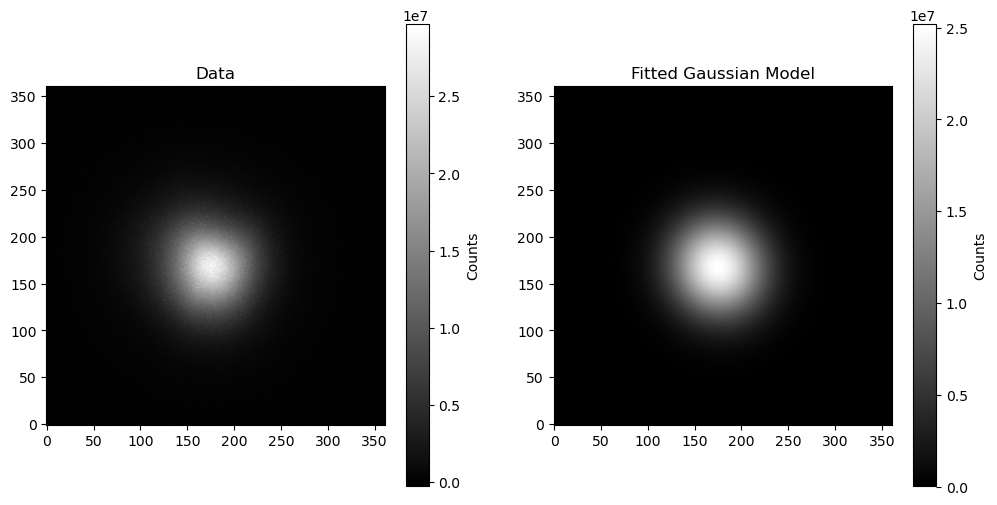

In [25]:
from astropy.modeling import models, fitting
import numpy as np

import matplotlib.pyplot as plt

image_stack_noclean = np.sum(ome_data[:5000], axis=0)
image_stack_clean = image_stack_noclean - np.median(image_stack_noclean)

# Define the radius for the fitting region
radius = 180

# Define the fitting region around the centroid
y_ref, x_ref = int(centroid_y), int(centroid_x)
y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]

# Extract the fitting region from the combined image
masked_data = image_stack_clean[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]

# Initialize the Gaussian model
gaussian_model = models.Gaussian2D(amplitude=masked_data.max(), x_mean=x_ref, y_mean=y_ref, x_stddev=1, y_stddev=1)

# Fit the model to the data
fitter = fitting.LevMarLSQFitter()
fitted_model = fitter(gaussian_model, x, y, masked_data)

# Calculate the FWHM
fwhm_x = 2.355 * fitted_model.x_stddev.value * plate_scale
fwhm_y = 2.355 * fitted_model.y_stddev.value * plate_scale

print(f"Fitted FWHM: {fwhm_x:.2f} x {fwhm_y:.2f} arcseconds")

# Plot the data and the fitted model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(masked_data, cmap='gray', origin='lower')
plt.title('Data')
plt.colorbar(label='Counts')

plt.subplot(1, 2, 2)
plt.imshow(fitted_model(x, y), cmap='gray', origin='lower')
plt.title('Fitted Gaussian Model')
plt.colorbar(label='Counts')

plt.show()

In [ ]:

def fit_speckle(data, filtered_speckles, radius, speckle_threshold, plate_scale):
    fwhm_results = []

    for speckle in filtered_speckles:
        y_ref, x_ref = speckle  
        masked_data = data.copy() 
        y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
        masked_data = masked_data[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
        masked_data[masked_data < 0] = 0 
        
        ###########################################################################
        #Se attivo, fa il fit in una regione circolare
        #distance = np.sqrt((x - x_ref)**2 + (y - y_ref)**2)
        #circular_mask = distance <= radius
        #masked_data = np.where(circular_mask, masked_data, 0)
        ##############################################################################
        
        # Set border pixels to 0
        masked_data[0, :] = 0
        masked_data[-1, :] = 0
        masked_data[:, 0] = 0
        masked_data[:, -1] = 0

        gaussian_model = models.Gaussian2D(amplitude=masked_data.max(), x_mean=x_ref, y_mean=y_ref, x_stddev=0.5, y_stddev=0.5)
        gaussian_model.amplitude.min = speckle_threshold
        gaussian_model.amplitude.max = masked_data.max()
        gaussian_model.x_mean.min = x_ref - 1
        gaussian_model.x_mean.max = x_ref + 1
        gaussian_model.y_mean.min = y_ref - 1
        gaussian_model.y_mean.max = y_ref + 1

        fitter = fitting.LevMarLSQFitter()
        fitted_model = fitter(gaussian_model, x, y, masked_data)

        fwhm_x = 2.355 * fitted_model.x_stddev.value * plate_scale
        fwhm_y = 2.355 * fitted_model.y_stddev.value * plate_scale
        fwhm_results.append((fwhm_y, fwhm_x))

    return np.array(fwhm_results)


# ---------------------------------------------------------------------------------------------
# Da qua in poi ci sono parti inutilizzate di codice
# ---------------------------------------------------------------------------------------------

# Trova speckle con CV2

No circles were found


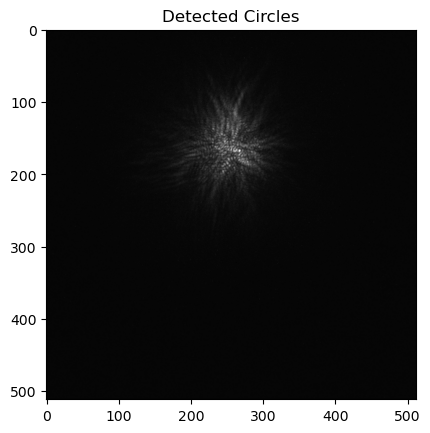

Pixel with maximum count: (np.int64(168), np.int64(268)) with count 32599
No circles were found
Square found with coordinates: [[[218 118]]

 [[218 217]]

 [[317 217]]

 [[317 118]]]
Square found with coordinates: [[[311 131]]

 [[312 130]]

 [[313 131]]

 [[312 132]]]


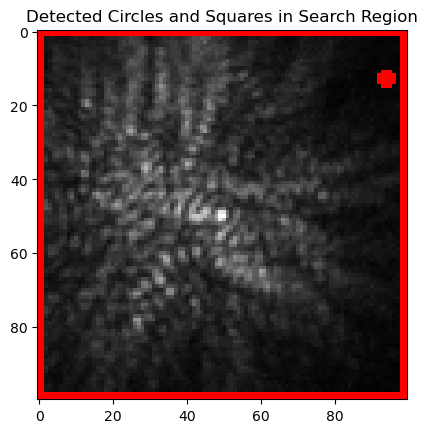

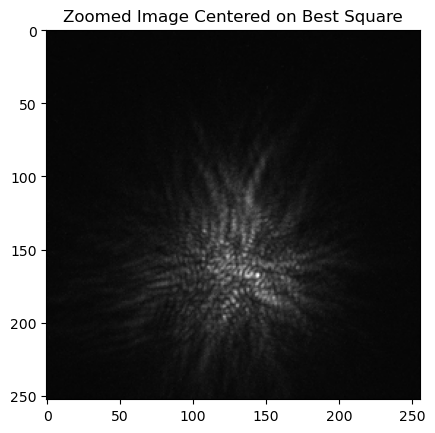

Speckle found at (y, x) = (108, 262) with value = 10026
Speckle found at (y, x) = (109, 262) with value = 10921
Speckle found at (y, x) = (110, 262) with value = 10558
Speckle found at (y, x) = (110, 263) with value = 10017
Speckle found at (y, x) = (111, 260) with value = 11137
Speckle found at (y, x) = (111, 261) with value = 13016
Speckle found at (y, x) = (112, 260) with value = 10105
Speckle found at (y, x) = (112, 261) with value = 11075
Speckle found at (y, x) = (112, 263) with value = 10796
Speckle found at (y, x) = (113, 260) with value = 10178
Speckle found at (y, x) = (113, 261) with value = 11968
Speckle found at (y, x) = (113, 262) with value = 10426
Speckle found at (y, x) = (113, 263) with value = 10422
Speckle found at (y, x) = (114, 260) with value = 11839
Speckle found at (y, x) = (114, 261) with value = 13310
Speckle found at (y, x) = (114, 262) with value = 13134
Speckle found at (y, x) = (114, 263) with value = 10824
Speckle found at (y, x) = (115, 259) with value 

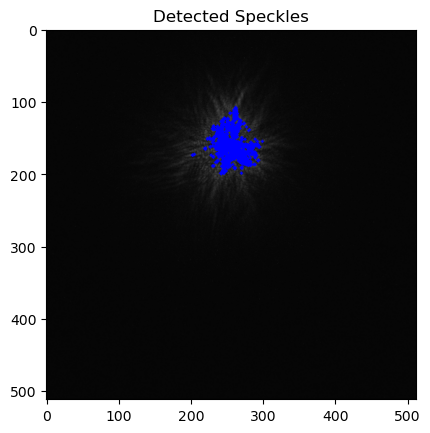

Real speckle found at (y, x) = (111, 261) with value = 13016
Real speckle found at (y, x) = (114, 261) with value = 13310
Real speckle found at (y, x) = (115, 261) with value = 14895
Real speckle found at (y, x) = (117, 261) with value = 15737
Real speckle found at (y, x) = (118, 261) with value = 15901
Real speckle found at (y, x) = (116, 255) with value = 10706
Real speckle found at (y, x) = (115, 259) with value = 12305
Real speckle found at (y, x) = (126, 243) with value = 12209
Real speckle found at (y, x) = (124, 251) with value = 12555
Real speckle found at (y, x) = (121, 263) with value = 13408
Real speckle found at (y, x) = (124, 262) with value = 11912
Real speckle found at (y, x) = (127, 268) with value = 12476
Real speckle found at (y, x) = (131, 251) with value = 16172
Real speckle found at (y, x) = (131, 258) with value = 12303
Real speckle found at (y, x) = (131, 268) with value = 13000
Real speckle found at (y, x) = (132, 243) with value = 12644
Real speckle found at (y

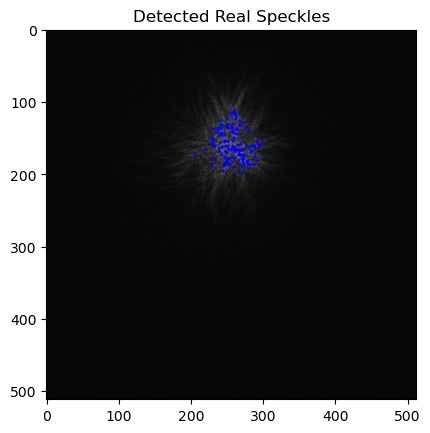

157


In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

# Convert the first image to grayscale and ensure it is of type uint8
gray_image = cv2.normalize(ome_data[0], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# Use HoughCircles to detect circles in the first image
circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=5, param1=50, param2=30, minRadius=2, maxRadius=5)

# If some circles are detected, print their coordinates and radii
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        print(f"Circle found at (x, y) = ({x}, {y}) with radius = {r}")
else:
    print("No circles were found")
    
    # Show the image with the circles found on it
output_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)

if circles is not None:
    for (x, y, r) in circles:
        cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)
        cv2.rectangle(output_image, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

plt.imshow(output_image)
plt.title('Detected Circles')
plt.show()


# Define the zoom factor
zoom_factor = 2

# Find the pixel with the maximum count
max_count_pixel = np.unravel_index(np.argmax(data), data.shape)
print(f"Pixel with maximum count: {max_count_pixel} with count {data[max_count_pixel]}")

# Define the region around the max count pixel to search for circles or squares
search_radius = 50
x_max, y_max = max_count_pixel[1], max_count_pixel[0]
x1 = max(x_max - search_radius, 0)
x2 = min(x_max + search_radius, data.shape[1])
y1 = max(y_max - search_radius, 0)
y2 = min(y_max + search_radius, data.shape[0])

# Crop the region around the max count pixel
search_region = data[y1:y2, x1:x2]

# Convert the search region to grayscale and ensure it is of type uint8
gray_search_region = cv2.normalize(search_region, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# Use HoughCircles to detect circles in the search region
circles = cv2.HoughCircles(gray_search_region, cv2.HOUGH_GRADIENT, dp=1.2, minDist=5, param1=50, param2=30, minRadius=2, maxRadius=5)

# If some circles are detected, print their coordinates and radii
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        print(f"Circle found at (x, y) = ({x + x1}, {y + y1}) with radius = {r}")
else:
    print("No circles were found")

# Find contours in the search region to detect squares
contours, _ = cv2.findContours(gray_search_region, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
squares = []
for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
    if len(approx) == 4:
        squares.append(approx)

# If some squares are detected, print their coordinates
if squares:
    for square in squares:
        print(f"Square found with coordinates: {square + [x1, y1]}")
else:
    print("No squares were found")

# Show the search region with the detected circles and squares
output_search_region = cv2.cvtColor(gray_search_region, cv2.COLOR_GRAY2BGR)

if circles is not None:
    for (x, y, r) in circles:
        cv2.circle(output_search_region, (x, y), r, (0, 255, 0), 2)
        cv2.rectangle(output_search_region, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

for square in squares:
    cv2.drawContours(output_search_region, [square], -1, (255, 0, 0), 2)

plt.imshow(output_search_region)
plt.title('Detected Circles and Squares in Search Region')
plt.show()
zoom_factor = 2

# Get the bounding box of the best square
x, y, w, h = cv2.boundingRect(best_square)

# Calculate the center of the square
center_x = x + w // 2
center_y = y + h // 2

# Define the zoomed area
x1 = max(center_x - width // (2 * zoom_factor), 0)
x2 = min(center_x + width // (2 * zoom_factor), width)
y1 = max(center_y - height // (2 * zoom_factor), 0)
y2 = min(center_y + height // (2 * zoom_factor), height)

# Crop the zoomed area from the original image
zoomed_image = output_image[y1:y2, x1:x2]

# Display the zoomed image
plt.imshow(zoomed_image)
plt.title('Zoomed Image Centered on Best Square')
plt.show()



# Fit con Moffat

In [ ]:
from photutils.psf import MoffatPSF
from astropy.modeling.fitting import LevMarLSQFitter
from photutils.background import LocalBackground, MMMBackground

data = ome_data[0]
#y_ref, x_ref = 146, 243  #coordinate del pixel con conteggi superiori al threshold
radius = 3
background = 1275
data_clean=data-background
data_clean=data
fwhms=[]

print(np.max(data_clean))
print(np.max(data))
#np.array(fwhms)
#print(data[y_ref,x_ref])
#print(data[y_ref,x_ref])
#print(coordinates)
#print(coordinates[0,0], coordinates[0,1])  #il primo è la y la seconda la x
#print(coordinates[1,0], coordinates[1,1])  #questo è il secondo punto nell'elenco

i=0
#i=13
for i in range(len(coordinates)):
    y_ref=coordinates[i,0]
    x_ref=coordinates[i,1]
    moffat_model = MoffatPSF(flux=data_clean[y_ref, x_ref], x_0=x_ref, y_0=y_ref, alpha=1.5, beta=2.5)
    moffat_model.alpha.fixed = False
    moffat_model.beta.fixed = False
    moffat_model.flux.min = data_clean[y_ref, x_ref]
    moffat_model.flux.max = data_clean[y_ref-radius:y_ref+radius, x_ref-radius:x_ref+radius].sum()/10        #-(background*(2*radius)**2)  #rimuove il background prendendo i conteggi
                                                                                                                #medi per pixel moltiplicati per tutta la superficie di fitting                                                                                  #  2*radius è la dimensione del lato del quadrato                                                    
    #print(moffat_model.flux.max)                                                                               
    fitter = LevMarLSQFitter()

    y, x = np.mgrid[y_ref-radius:y_ref+radius, x_ref-radius:x_ref+radius]
    masked_data = data_clean[y_ref-radius:y_ref+radius, x_ref-radius:x_ref+radius]  
    fitted_model = fitter(moffat_model, x, y, masked_data)
    fwhm=2*fitted_model.alpha*np.sqrt(2**(1/fitted_model.beta)-1)

    #print(f"Centroid (x, y): ({fitted_model.x_0.value}, {fitted_model.y_0.value}, alpha={fitted_model.alpha.value}, beta={fitted_model.beta.value}, total flux={fitted_model.flux.value})")
    print(f"FWHM {i+1}/{len(coordinates)}: {fwhm}")
    
    fwhms.append(fwhm)


32599
32599
FWHM 1/1384: 2.1414393644142193
FWHM 2/1384: 2.261390683085694
FWHM 3/1384: 2.2078198044827926
FWHM 4/1384: 2.442955436345215
FWHM 5/1384: 2.024158774538058
FWHM 6/1384: 2.3505559399425824
FWHM 7/1384: 2.305091056476608
FWHM 8/1384: 2.6010671559332064
FWHM 9/1384: 2.3829121399388784
FWHM 10/1384: 1.8860761120905247
FWHM 11/1384: 2.041726993570632
FWHM 12/1384: 2.1171693640116565
FWHM 13/1384: 1.9872205183158738
FWHM 14/1384: 1.941245786398265
FWHM 15/1384: 2.0637695702353662
FWHM 16/1384: 2.128224240977219
FWHM 17/1384: 1.980055479912323
FWHM 18/1384: 1.8946699750507665
FWHM 19/1384: 2.0621120300610056
FWHM 20/1384: 2.2690278942411926
FWHM 21/1384: 2.29532187237227
FWHM 22/1384: 2.073504313251906
FWHM 23/1384: 2.0069897110204833
FWHM 24/1384: 2.140680810013258
FWHM 25/1384: 2.000341447947393
FWHM 26/1384: 2.1344841170532183
FWHM 27/1384: 2.337621131425154
FWHM 28/1384: 2.3633736286361624
FWHM 29/1384: 2.182206831168119
FWHM 30/1384: 1.9040579395525479
FWHM 31/1384: 1.997471

## Correzione Moffat Fitting

In [ ]:
from photutils.psf import MoffatPSF
from astropy.modeling.fitting import LevMarLSQFitter
from photutils.background import LocalBackground

data = ome_data[0]
#y_ref, x_ref = 146, 243  #coordinate del pixel con conteggi superiori al threshold
radius = 3
background = 1275
data_clean=data-background
data_clean=data
fwhms=[]

#print(np.max(data_clean))
#print(np.max(data))
#np.array(fwhms)
#print(data[y_ref,x_ref])
#print(data[y_ref,x_ref])
#print(coordinates)
#print(coordinates[0,0], coordinates[0,1])  #il primo è la y la seconda la x
#print(coordinates[1,0], coordinates[1,1])  #questo è il secondo punto nell'elenco

i=0
#i=13
for i in range(len(coordinates)):
    y_ref=coordinates[i,0]
    x_ref=coordinates[i,1]
    moffat_model = MoffatPSF(flux=data_clean[y_ref, x_ref], x_0=x_ref, y_0=y_ref, alpha=1.5, beta=2.5)
    moffat_model.alpha.fixed = False
    moffat_model.beta.fixed = False
    moffat_model.flux.min = data_clean[y_ref, x_ref]
    moffat_model.flux.max = data_clean[y_ref-radius:y_ref+radius, x_ref-radius:x_ref+radius].sum()/10        #-(background*(2*radius)**2)  #rimuove il background prendendo i conteggi
                                                                                                                #medi per pixel moltiplicati per tutta la superficie di fitting                                                                                                   
    fitter = LevMarLSQFitter()

    y, x = np.mgrid[y_ref-radius:y_ref+radius, x_ref-radius:x_ref+radius]
    masked_data = data_clean[y_ref-radius:y_ref+radius, x_ref-radius:x_ref+radius]  
    
    fitted_model=fitter(moffat_model, x, y, masked_data, maxiter=1000, acc=1.0e-9, epsilon=1.49e-08, estimate_jacobian=True, weights=None)
    
    
    
    # fitted_model = fitter(moffat_model, x, y, masked_data)
    fwhm=2*fitted_model.alpha*np.sqrt(2**(1/fitted_model.beta)-1)
    
    print(f"FWHM {i+1}/{len(coordinates)}: {fwhm}")
   
    fwhms.append(fwhm)

FWHM 1/1384: 2.1514759560552807
FWHM 2/1384: 2.323861931400842
FWHM 3/1384: 2.3455167213108687
FWHM 4/1384: 2.4441481421264997
FWHM 5/1384: 2.0801822999161668
FWHM 6/1384: 2.3567274662418436
FWHM 7/1384: 2.2935719045242253
FWHM 8/1384: 2.551484887933509
FWHM 9/1384: 2.506351272154638
FWHM 10/1384: 1.895384103956004
FWHM 11/1384: 2.103004110701122
FWHM 12/1384: 2.1531646662075015
FWHM 13/1384: 1.9939512240313624
FWHM 14/1384: 1.9602390548098294
FWHM 15/1384: 2.1397858327647103
FWHM 16/1384: 2.1667682452346835
FWHM 17/1384: 2.0203333665350787
FWHM 18/1384: 1.9313108265585164
FWHM 19/1384: 2.1073385019420434
FWHM 20/1384: 2.300535508619597
FWHM 21/1384: 2.324072347853626
FWHM 22/1384: 2.1499986418475383
FWHM 23/1384: 2.01036190087027
FWHM 24/1384: 2.127328007558239
FWHM 25/1384: 2.000339611394239
FWHM 26/1384: 2.1562041992333594
FWHM 27/1384: 2.3576951615816064
FWHM 28/1384: 2.394861052823666
FWHM 29/1384: 2.1724764817195843
FWHM 30/1384: 1.904920706691914
FWHM 31/1384: 2.1205581003524987

KeyboardInterrupt: 

## Fit di una sola speckle con Moffat

centroid: y= 172 x= 237
Fitted centroid (x, y): (236.3709937811014, 172.41773546357197, alpha=18.698328771089876, beta=296.9579015172897, total flux=23392.3)
FWHM 1001/1384: 1.807804872308927


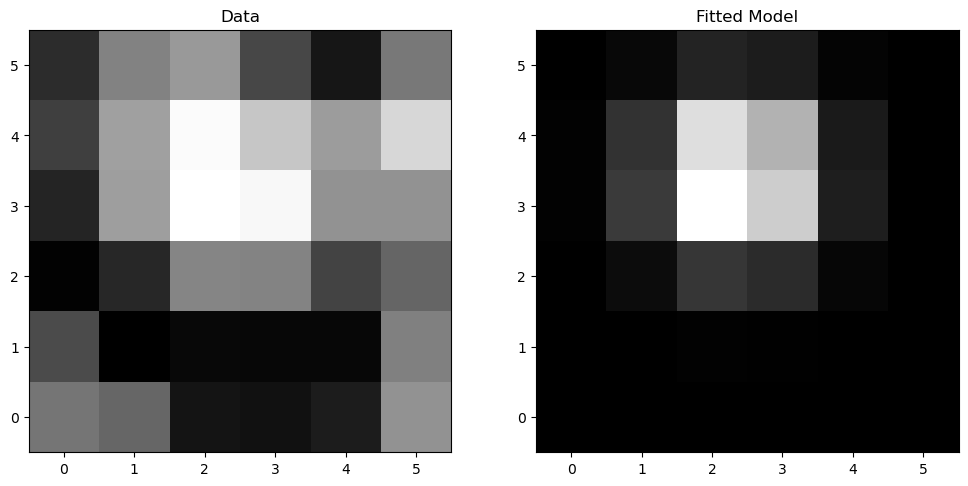

In [ ]:
from photutils.psf import MoffatPSF
from astropy.modeling.fitting import LevMarLSQFitter

data = ome_data[0]
y_ref, x_ref = 146, 243  #coordinate del pixel con conteggi superiori al threshold
radius = 3
background = 1275
data_clean=data-background  #tolto il background dai dati, molto grezzo, background preso da DS9
i=0
#print(data[y_ref,x_ref])
#print(data[y_ref,x_ref])
#print(coordinates)
#print(coordinates[0,0], coordinates[0,1])  #il primo è la y la seconda la x
#print(coordinates[1,0], coordinates[1,1])  #questo è il secondo punto nell'elenco
i=1000
# Find the index of a particular value inside the array coordinates
value = [167, 257]

y_ref=coordinates[i,0]
x_ref=coordinates[i,1]
moffat_model = MoffatPSF(flux=data_clean[y_ref, x_ref], x_0=x_ref, y_0=y_ref, alpha=1.5, beta=2.5)
moffat_model.alpha.fixed = False
moffat_model.beta.fixed = False
moffat_model.flux.min = data_clean[y_ref, x_ref]
moffat_model.flux.max = data_clean[y_ref-radius:y_ref+radius, x_ref-radius:x_ref+radius].sum()/10        #-(background*(2*radius)**2)  #rimuove il background prendendo i conteggi
                                                                                                                #medi per pixel moltiplicati per tutta la superficie di fitting                                                                                  #  2*radius è la dimensione del lato del quadrato                                                    
#print(moffat_model.flux.max)                                                                               
fitter = LevMarLSQFitter()

y, x = np.mgrid[y_ref-radius:y_ref+radius, x_ref-radius:x_ref+radius]
masked_data = data_clean[y_ref-radius:y_ref+radius, x_ref-radius:x_ref+radius]  
fitted_model = fitter(moffat_model, x, y, masked_data)
fwhm=2*fitted_model.alpha*np.sqrt(2**(1/fitted_model.beta)-1)

print('centroid: y=',y_ref,'x=',x_ref)
print(f"Fitted centroid (x, y): ({fitted_model.x_0.value}, {fitted_model.y_0.value}, alpha={fitted_model.alpha.value}, beta={fitted_model.beta.value}, total flux={fitted_model.flux.value})")
print(f"FWHM {i+1}/{len(coordinates)}: {fwhm}")
#print(fitted.model.)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(masked_data, cmap='gray', origin='lower')
plt.title('Data')
plt.subplot(1, 2, 2)
plt.imshow(fitted_model(x, y), cmap='gray', origin='lower')
plt.title('Fitted Model')
plt.show()